In [1]:
import pickle
import os
import sys
import glob
# import torch
import numpy as np
import pandas as pd
import scipy.io
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from scipy import signal
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from statistics import mean
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact
from scipy.stats import ranksums
from scipy.stats import pearsonr

# jupyter notebook display setting for all data structures
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
np.set_printoptions(threshold=np.inf)

In [2]:
# load the dictionary of dictionaries from a pickle file
with open('../../data/gcPBM_data/panset.pkl', 'rb') as handle:
    panset = pickle.load(handle)

# load the new feature dictionaries
with open('/project2/xinhe/waqaas/DNA-breathing/data/gcPBM_features/compiled_bubble_data/mad.pkl', 'rb') as handle:
    mad_features = pickle.load(handle)
with open('/project2/xinhe/waqaas/DNA-breathing/data/gcPBM_features/compiled_bubble_data/max.pkl', 'rb') as handle:
    max_features = pickle.load(handle)
with open('/project2/xinhe/waqaas/DNA-breathing/data/gcPBM_features/compiled_bubble_data/myc.pkl', 'rb') as handle:
    myc_features = pickle.load(handle)

In [3]:
mad_data = panset['mad']
max_data = panset['max']
myc_data = panset['myc']

In [4]:
# collapse the train and test partitions into one
mad = {}
for key in mad_data.keys():
    data = mad_data[key]
    for key in data.keys():
        mad[key] = data[key]
mad_data = mad.copy()
max = {}
for key in max_data.keys():
    data = max_data[key]
    for key in data.keys():
        max[key] = data[key]
max_data = max.copy()
myc = {}
for key in myc_data.keys():
    data = myc_data[key]
    for key in data.keys():
        myc[key] = data[key]
myc_data = myc.copy()

In [5]:
# replace the old feature dictionaries with the new ones
y_slice = 10
z_slice = 6
mad = {}
for key in mad_data.keys():
    data = mad_data[key]
    features = mad_features[str(key)]
    mad[key] = {'seq': data['seq'], 'label': data['label'], 'bubble': features['bubbles'][4:40,y_slice,z_slice]/80000, 'flipping': features['flip'][4:40]/80000, 'coords': features['coord'][4:40]/80000, 'coordssquared': features['coord_squared'][4:40]/80000}
mad_data = mad.copy()
max = {}
for key in max_data.keys():
    data = max_data[key]
    features = max_features[str(key)]
    max[key] = {'seq': data['seq'], 'label': data['label'], 'bubble': features['bubbles'][4:40,y_slice,z_slice]/80000, 'flipping': features['flip'][4:40]/80000, 'coords': features['coord'][4:40]/80000, 'coordssquared': features['coord_squared'][4:40]/80000}
max_data = max.copy()
myc = {}
for key in myc_data.keys():
    data = myc_data[key]
    features = myc_features[str(key)]
    myc[key] = {'seq': data['seq'], 'label': data['label'], 'bubble': features['bubbles'][4:40,y_slice,z_slice]/80000, 'flipping': features['flip'][4:40]/80000, 'coords': features['coord'][4:40]/80000, 'coordssquared': features['coord_squared'][4:40]/80000}
myc_data = myc.copy()

In [6]:
# extract the sequence ids from the data
mad_ids = [seq for seq in mad_data.keys()]
max_ids = [seq for seq in max_data.keys()]
myc_ids = [seq for seq in myc_data.keys()]

In [7]:
agnosticset = {}
for tf in [mad_data, max_data, myc_data]:
    if tf == mad_data:
        name = 'mad'
    elif tf == max_data:
        name = 'max'
    else:
        name = 'myc'
    for seq_id in tf.keys():
        agnosticset[f'{name}_{seq_id}'] = tf[seq_id]['bubble']

# bubble_binary Determination

In [8]:
# flatten all the bubble values for each sequence in each tf dictionary
mad_bubble = []
for i in mad_ids:
    mad_bubble.append(mad_data[i]['bubble'].flatten())
# flatten mad_bubble
mad_bubble = [item for sublist in mad_bubble for item in sublist]
mad_bubble = np.array(mad_bubble)
mad_percentile = np.percentile(mad_bubble, 95)
max_bubble = []
for i in max_ids:
    max_bubble.append(max_data[i]['bubble'].flatten())
# flatten max_bubble
max_bubble = [item for sublist in max_bubble for item in sublist]
max_bubble = np.array(max_bubble)
max_percentile = np.percentile(max_bubble, 95)
myc_bubble = []
for i in myc_ids:
    myc_bubble.append(myc_data[i]['bubble'].flatten())
# flatten myc_bubble
myc_bubble = [item for sublist in myc_bubble for item in sublist]
myc_bubble = np.array(myc_bubble)
myc_percentile = np.percentile(myc_bubble, 95)

print(mad_percentile, max_percentile, myc_percentile)

0.000140875 0.000149125 0.0001425


In [9]:
for tf in [mad_data, max_data, myc_data]:
    if tf == mad_data:
        name = 'mad'
        value_set = mad_percentile
    elif tf == max_data:
        name = 'max'
        value_set = max_percentile
    else:
        name = 'myc'
        value_set = myc_percentile
    arrays = 0
    for bubble in agnosticset.keys():
        if name in bubble:
            if np.max(agnosticset[bubble]) > value_set:
                arrays += 1

    print(f'TF: {name}')
    print(f'Total arrays: {len(tf.keys())}')
    print(f'Arrays with a maximum value greater than {value_set:.4f}: {arrays}')
    print(f'Percentage of arrays with a maximum value greater than {value_set:.4f}: {arrays/len(tf.keys())*100:.2f}%')

TF: mad
Total arrays: 7534
Arrays with a maximum value greater than 0.0001: 1266
Percentage of arrays with a maximum value greater than 0.0001: 16.80%
TF: max
Total arrays: 8568
Arrays with a maximum value greater than 0.0001: 1361
Percentage of arrays with a maximum value greater than 0.0001: 15.88%
TF: myc
Total arrays: 6926
Arrays with a maximum value greater than 0.0001: 1186
Percentage of arrays with a maximum value greater than 0.0001: 17.12%


In [10]:
for tf in [mad_data, max_data, myc_data]:
    if tf == mad_data:
        name = 'mad'
        value_set = mad_percentile
    elif tf == max_data:
        name = 'max'
        value_set = max_percentile
    else:
        name = 'myc'
        value_set = myc_percentile
    arrays = 0
    for bubble in agnosticset.keys():
        if name in bubble:
            if np.max(agnosticset[bubble]) > value_set:
                tf[int(bubble.split('_')[1])]['bubble_binary'] = 1
            else:
                tf[int(bubble.split('_')[1])]['bubble_binary'] = 0

now we make dictionaries that will contain the seq_ids(?) and labels for bubble positive and bubble negative data respectively, presumably for statistical analysis

In [11]:
tf_label = {}
tf_bubble_binary = {}
for tf in [mad_data, max_data, myc_data]:
    if tf == mad_data:
        name = 'mad'
    elif tf == max_data:
        name = 'max'
    else:
        name = 'myc'
    tf_label[name] = []
    tf_bubble_binary[name] = []
    for seq_id in tf.keys():
        tf_label[name].append(tf[seq_id]['label'])
        tf_bubble_binary[name].append(tf[seq_id]['bubble_binary'])

In [12]:
# divide the tf_label data into bubble positive and bubble negative data
mad_label_bubble_pos = []
mad_label_bubble_neg = []
for n, i in enumerate(tf_label['mad']):
    if tf_bubble_binary['mad'][n] == 1:
        mad_label_bubble_pos.append(i)
    else:
        mad_label_bubble_neg.append(i)

max_label_bubble_pos = []
max_label_bubble_neg = []
for n, i in enumerate(tf_label['max']):
    if tf_bubble_binary['max'][n] == 1:
        max_label_bubble_pos.append(i)
    else:
        max_label_bubble_neg.append(i)

myc_label_bubble_pos = []
myc_label_bubble_neg = []
for n, i in enumerate(tf_label['myc']):
    if tf_bubble_binary['myc'][n] == 1:
        myc_label_bubble_pos.append(i)
    else:
        myc_label_bubble_neg.append(i)

# motif_seq Determination

We use the following code to parse HOMER's output into a motif sequence for our dictionary. We will probably replace this as FIMO comes in.

In [13]:
panset = {'mad': mad_data, 'max': max_data, 'myc': myc_data}

In [14]:
# find number of sequences per tf
for tf in panset.keys():
    count = 0
    for seq_id in panset[tf].keys():
        count += 1
    print(tf, count)

mad 7534
max 8568
myc 6926


In [15]:
# count and print the number of bubble positive and bubble negative sequences for each tf
for tf in panset.keys():
    bubble_pos = 0
    bubble_neg = 0
    for seq_id in panset[tf].keys():
        if panset[tf][seq_id]['bubble_binary'] == 1:
            bubble_pos += 1
        else:
            bubble_neg += 1
    print(f'{tf} bubble positive: {bubble_pos}')
    print(f'{tf} bubble negative: {bubble_neg}')

mad bubble positive: 1266
mad bubble negative: 6268
max bubble positive: 1361
max bubble negative: 7207
myc bubble positive: 1186
myc bubble negative: 5740


In [16]:
# load the fimo output files
fimo_myc = pd.read_csv('/project2/xinhe/waqaas/TF_fastas/meme/myc_fimo/fimo.tsv', sep='\t')
fimo_max = pd.read_csv('/project2/xinhe/waqaas/TF_fastas/meme/max_fimo/fimo.tsv', sep='\t')

In [17]:
# preview the fimo output for max
fimo_myc.head()

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
0,MA0147.3,MYC,6871.0,13.0,24.0,+,17.2927,2.560000e-08,0.000944,GGCCACGTGCCC
1,MA0147.3,MYC,512.0,13.0,24.0,+,17.2927,2.560000e-08,0.000944,GGCCACGTGCCC
2,MA0147.3,MYC,1165.0,13.0,24.0,+,17.2927,2.560000e-08,0.000944,GGCCACGTGCCC
3,MA0147.3,MYC,6901.0,13.0,24.0,+,17.2927,2.560000e-08,0.000944,GGCCACGTGCCC
4,MA0147.3,MYC,698.0,13.0,24.0,+,17.2927,2.560000e-08,0.000944,GGCCACGTGCCC


In [18]:
# drop NA values for the sequence_name column in the fimo output for max
fimo_max = fimo_max.dropna(subset=['sequence_name'])
# drop NA values for the sequence_name column in the fimo output for myc
fimo_myc = fimo_myc.dropna(subset=['sequence_name'])

In [19]:
# turn all the sequence_name values in the fimo output for max into int values using as type int
fimo_max['sequence_name'] = fimo_max['sequence_name'].astype(int)
# turn all the sequence_name values in the fimo output for myc into int values using as type int
fimo_myc['sequence_name'] = fimo_myc['sequence_name'].astype(int)
# turn all the sequence_name values in the fimo output for max into str values using as type str
fimo_max['sequence_name'] = fimo_max['sequence_name'].astype(str)
# turn all the sequence_name values in the fimo output for myc into str values using as type str
fimo_myc['sequence_name'] = fimo_myc['sequence_name'].astype(str)

In [20]:
print(fimo_max.shape)
print(fimo_myc.shape)

# find the number of unique sequences in the fimo output for max
print(len(fimo_max['sequence_name'].unique()))
# find the number of unique sequences in the fimo output for myc
print(len(fimo_myc['sequence_name'].unique()))

(13325, 10)
(10682, 10)
7228
5917


In [21]:
# count the instances of each value of strand in the rows of the fimo output
print('fimo_max')
print(fimo_max['strand'].value_counts())
print('fimo_myc')
print(fimo_myc['strand'].value_counts())

fimo_max
strand
+    6672
-    6653
Name: count, dtype: int64
fimo_myc
strand
+    5365
-    5317
Name: count, dtype: int64


In [22]:
# give a statistical summary of the p-value column of the fimo output for max
print(fimo_max['p-value'].describe())
# give a statistical summary of the p-value column of the fimo output for myc
print(fimo_myc['p-value'].describe())

count    1.332500e+04
mean     3.589104e-04
std      2.774100e-04
min      6.130000e-07
25%      1.110000e-04
50%      3.100000e-04
75%      5.530000e-04
max      1.000000e-03
Name: p-value, dtype: float64
count    1.068200e+04
mean     2.431442e-04
std      2.486313e-04
min      2.560000e-08
25%      5.300000e-05
50%      1.565000e-04
75%      3.550000e-04
max      9.980000e-04
Name: p-value, dtype: float64


In [23]:
# fimo motif_seq and p-value assignment
for tf in panset.keys():
    if tf in ['mad']:
        continue
    if tf == 'max':
        fasta = fimo_max
    elif tf == 'myc':
        fasta = fimo_myc
    for seq_id in panset[tf].keys():
        panset[tf][seq_id]['motif_seq_positive'] = np.zeros(len(panset[tf][seq_id]['seq']))
        panset[tf][seq_id]['motif_seq_negative'] = np.zeros(len(panset[tf][seq_id]['seq']))
        panset[tf][seq_id]['motif_seq'] = np.zeros(len(panset[tf][seq_id]['seq']))
        panset[tf][seq_id]['p-value_positive'] = 0
        panset[tf][seq_id]['p-value_negative'] = 0
        for fasta_id in fasta['sequence_name']:
            if fasta_id == str(seq_id):
                # get the Sequence from the dataframe
                if fasta[fasta['sequence_name'] == fasta_id]['strand'].values[0] == '+':
                    motif_seq = fasta[fasta['sequence_name'] == fasta_id]['matched_sequence'].values[0]
                    pos = panset[tf][seq_id]['seq'].index(motif_seq)
                    panset[tf][seq_id]['motif_seq_positive'][pos:pos+len(motif_seq)] = 1
                    panset[tf][seq_id]['p-value_positive'] = fasta[fasta['sequence_name'] == fasta_id]['p-value'].values[0]
                elif fasta[fasta['sequence_name'] == fasta_id]['strand'].values[0] == '-':
                    motif_seq = fasta[fasta['sequence_name'] == fasta_id]['matched_sequence'].values[0]
                    negative_strand = ''
                    for base in panset[tf][seq_id]['seq']:
                        if base == 'A':
                            negative_strand += 'T'
                        elif base == 'T':
                            negative_strand += 'A'
                        elif base == 'C':
                            negative_strand += 'G'
                        elif base == 'G':
                            negative_strand += 'C'
                    # reverse the string
                    motif_seq = motif_seq[::-1]
                    if motif_seq in negative_strand:
                        pos = negative_strand.index(motif_seq)
                    # create np.array of zeros with length of the sequence
                    # make the positions of motif_seq to len(motif_seq) + pos in panset[tf][fasta_id]['seq'] equal to 1
                        panset[tf][seq_id]['motif_seq_negative'][pos:pos+len(motif_seq)] = 1
                        panset[tf][seq_id]['p-value_negative'] = fasta[fasta['sequence_name'] == fasta_id]['p-value'].values[0]
                # motif_seq as a concatenation of motif_seq_positive and motif_seq_negative
                for i in range(len(panset[tf][seq_id]['seq'])):
                    if panset[tf][seq_id]['motif_seq_positive'][i] == 1:
                        panset[tf][seq_id]['motif_seq'][i] = 1
                    elif panset[tf][seq_id]['motif_seq_negative'][i] == 1:
                        panset[tf][seq_id]['motif_seq'][i] = 1                    

In [24]:
# fimo motif_binary and strong/weak assignment
for tf in panset.keys():
    if tf == 'mad':
        continue
    no_motif = 0
    strong_motifs = 0
    weak_motifs = 0
    for seq_id in panset[tf].keys():
        panset[tf][seq_id]['strong_motif_binary'] = 0
        panset[tf][seq_id]['weak_motif_binary'] = 0
        # p-value threshold of 0.0001, less than or equal to 0.0001 is strong, greater than 0.0001 is weak
        if panset[tf][seq_id]['p-value_positive'] == 0 and panset[tf][seq_id]['p-value_negative'] == 0:
            no_motif += 1
        elif 0 < panset[tf][seq_id]['p-value_positive'] <= 0.0001 or 0 < panset[tf][seq_id]['p-value_negative'] <= 0.0001:
            panset[tf][seq_id]['strong_motif_binary'] = 1
            strong_motifs += 1
        elif panset[tf][seq_id]['p-value_positive'] > 0.0001 or panset[tf][seq_id]['p-value_negative'] > 0.0001:
            panset[tf][seq_id]['weak_motif_binary'] = 1
            weak_motifs += 1
    print(f'{tf} strong motifs: {strong_motifs}')
    print(f'{tf} weak motifs: {weak_motifs}')
    print(f'{tf} no motifs: {no_motif}')

max strong motifs: 1877
max weak motifs: 5351
max no motifs: 1340
myc strong motifs: 2636
myc weak motifs: 3281
myc no motifs: 1009


In [25]:
# counts of positive, negative, strong, and weak motifs as well as the total number of motifs per tf
for tf in panset.keys():
    if tf == 'mad':
        continue
    positive_motifs = 0
    negative_motifs = 0
    strong_motifs = 0
    weak_motifs = 0
    total_motifs = 0
    total_sequences = 0
    for seq_id in panset[tf].keys():
        total_sequences += 1
        if sum(panset[tf][seq_id]['motif_seq_positive']) != 0:
            positive_motifs += 1
        if sum(panset[tf][seq_id]['motif_seq_negative']) != 0:
            negative_motifs += 1
        strong_motifs += panset[tf][seq_id]['strong_motif_binary']
        weak_motifs += panset[tf][seq_id]['weak_motif_binary']
        if sum(panset[tf][seq_id]['motif_seq_positive']) != 0 or sum(panset[tf][seq_id]['motif_seq_negative']) != 0:
            total_motifs += 1
    print(tf)
    print(f'positive motifs: {positive_motifs}')
    print(f'negative motifs: {negative_motifs}')
    print(f'strong motifs: {strong_motifs}')
    print(f'weak motifs: {weak_motifs}')
    print(f'total motifs: {total_motifs}')
    print(f'total sequences: {total_sequences}')

max
positive motifs: 3988
negative motifs: 3240
strong motifs: 1877
weak motifs: 5351
total motifs: 7228
total sequences: 8568
myc
positive motifs: 3139
negative motifs: 2778
strong motifs: 2636
weak motifs: 3281
total motifs: 5917
total sequences: 6926


In [26]:
# create a table in markdown of each tf with the counts of positive, negative, strong, and weak motifs as well as the total number of motifs, total sequences, and total bubble positive sequences
# print the header of the table
print('| TF | Strong Motifs | Weak Motifs | Total Motifs | Total Sequences | Total Bubble Positive |')
for tf in panset.keys():
    if tf == 'mad':
        continue
    strong_motifs = 0
    weak_motifs = 0
    total_motifs = 0
    total_sequences = 0
    total_bubble_positive = 0
    for seq_id in panset[tf].keys():
        total_sequences += 1
        strong_motifs += panset[tf][seq_id]['strong_motif_binary']
        weak_motifs += panset[tf][seq_id]['weak_motif_binary']
        if panset[tf][seq_id]['strong_motif_binary'] == 1 or panset[tf][seq_id]['weak_motif_binary'] == 1:
            total_motifs += 1
        if panset[tf][seq_id]['bubble_binary'] == 1:
            total_bubble_positive += 1
    print(f'| {tf} | {strong_motifs} | {weak_motifs} | {total_motifs} | {total_sequences} | {total_bubble_positive} |')

| TF | Strong Motifs | Weak Motifs | Total Motifs | Total Sequences | Total Bubble Positive |
| max | 1877 | 5351 | 7228 | 8568 | 1361 |
| myc | 2636 | 3281 | 5917 | 6926 | 1186 |


# bubble_seq Determination

In [27]:
# use the 0.03 threshold at any timepoint to create a binary array of bubble values for each sequence
for tf in panset.keys():
    if tf == 'mad':
        continue
    if tf == 'max':
        value_set = max_percentile
        print(max_percentile)
    else:
        value_set = myc_percentile
        print(myc_percentile)
    for seq_id in panset[tf].keys():
        panset[tf][seq_id]['bubble_seq'] = np.zeros(len(panset[tf][seq_id]['seq']))
        for i in range(len(panset[tf][seq_id]['bubble'])):
            if panset[tf][seq_id]['bubble'][i] > value_set:
                panset[tf][seq_id]['bubble_seq'][i] = 1
                break

0.000149125
0.0001425


# motif_binary and motif_and_bubble_binary Determination

In [28]:
for tf in panset.keys():
    if tf == 'mad':
        continue
    for seq_id in panset[tf].keys():
        panset[tf][seq_id]['strong_motif_and_bubble_binary'] = 0
        panset[tf][seq_id]['weak_motif_and_bubble_binary'] = 0
        panset[tf][seq_id]['motif_and_bubble_binary'] = 0
        if panset[tf][seq_id]['strong_motif_binary'] == 1 and panset[tf][seq_id]['bubble_binary'] == 1:
            panset[tf][seq_id]['motif_and_bubble_binary'] = 1
            panset[tf][seq_id]['strong_motif_and_bubble_binary'] = 1
        elif panset[tf][seq_id]['weak_motif_binary'] == 1 and panset[tf][seq_id]['bubble_binary'] == 1:
            panset[tf][seq_id]['motif_and_bubble_binary'] = 1
            panset[tf][seq_id]['weak_motif_and_bubble_binary'] = 1

Now we try to do the Fischer test

In [29]:
affinity = {}
for tf in panset.keys():
    affinity[tf] = {}
    for seq_id in panset[tf].keys():
        affinity[tf][seq_id] = panset[tf][seq_id]['label']

# keep only the seq_ids in affinity that have the top 20% binding affinity

# Calculate the 20th percentile of binding affinity for each TF and part
# percentile_cutoff = 20
# for tf in affinity.keys():
#     seq_ids = list(affinity[tf].keys())
#     binding_affinities = [affinity[tf][seq_id] for seq_id in seq_ids]
#     cutoff_value = np.percentile(binding_affinities, 100 - percentile_cutoff)

#     # Keep only the seq_ids in affinity that have the top 20% binding affinity
#     top_20_seq_ids = [seq_id for seq_id in seq_ids if affinity[tf][seq_id] >= cutoff_value]
#     affinity[tf] = {seq_id: affinity[tf][seq_id] for seq_id in top_20_seq_ids}

In [30]:
fischer = {}

for tf in panset.keys():
    if tf == 'mad':
        continue
    fischer[tf] = {}
    L = 0
    B = 0
    M = 0
    x = 0
    for seq_id in affinity[tf].keys():
        if seq_id in panset[tf].keys():
            L += 36
            if panset[tf][seq_id]['bubble_binary'] == 0:
                for i in range(36):
                    if panset[tf][seq_id]['strong_motif_binary'] == 1 and (panset[tf][seq_id]['motif_seq_positive'][i] == 1 or panset[tf][seq_id]['motif_seq_negative'][i] == 1):
                        M += 1
            else:
                for i in range(36):
                    if panset[tf][seq_id]['bubble_seq'][i] == 1:
                        B += 1
                    if panset[tf][seq_id]['strong_motif_binary'] == 1 and (panset[tf][seq_id]['motif_seq_positive'][i] == 1 or panset[tf][seq_id]['motif_seq_negative'][i] == 1):
                        M += 1
                    if panset[tf][seq_id]['strong_motif_binary'] == 1 and (panset[tf][seq_id]['bubble_seq'][i] == 1 and (panset[tf][seq_id]['motif_seq_positive'][i] == 1 or panset[tf][seq_id]['motif_seq_negative'][i] == 1)):
                        x += 1
    fischer[tf]['L'] = L
    fischer[tf]['B'] = B
    fischer[tf]['M'] = M
    fischer[tf]['x'] = x
                

In [31]:
fischer

{'max': {'L': 308448, 'B': 1361, 'M': 18770, 'x': 46},
 'myc': {'L': 249336, 'B': 1186, 'M': 31632, 'x': 85}}

In [32]:
def conduct_fisher_test(fischer_scores):
    for tf, data in fischer_scores.items():
        L = data['L']
        B = data['B']
        M = data['M']
        x = data['x']

        # Contingency table
        contingency_table = [[x, M - x], [B - x, L - M - B + x]]

        # Perform Fisher's exact test
        odds_ratio, p_value = fisher_exact(contingency_table)

        # Print results
        print(f"TF: {tf}")
        print(f"Contingency Table:")
        print(f"         | Bubble+ | Bubble-")
        print(f"Motif+   |   {x}   |   {M - x}")
        print(f"Motif-   |   {B - x}   |   {L - M - B + x}")
        print(f"Odds Ratio: {odds_ratio}")
        print(f"P-value: {p_value}\n")

In [33]:
conduct_fisher_test(fischer)

TF: max
Contingency Table:
         | Bubble+ | Bubble-
Motif+   |   46   |   18724
Motif-   |   1315   |   288363
Odds Ratio: 0.5387322587955679
P-value: 8.510400968969282e-06

TF: myc
Contingency Table:
         | Bubble+ | Bubble-
Motif+   |   85   |   31547
Motif-   |   1101   |   216603
Odds Ratio: 0.5300758377124949
P-value: 1.0090991397916577e-09



Now we perform the linear test

In [34]:
import statsmodels.api as sm
from sklearn.metrics import r2_score
from scipy.stats import f

def calculate_statistics(X, y):
    # Add a constant term for the intercept
    X = sm.add_constant(X)
    
    # Fit the model using statsmodels
    model = sm.OLS(y, X).fit()
    
    # Get predicted values
    y_pred = model.predict(X)
    
    # Residuals
    residuals = y - y_pred
    
    # R-squared
    r_squared = r2_score(y, y_pred)
    
    # Degrees of freedom
    n = X.shape[0]
    p = X.shape[1] - 1
    df_residual = n - p - 1
    
    # Mean squared error
    mse = np.mean(residuals**2)
    
    # F-statistic and p-value
    ssr = np.sum(residuals**2)
    sst = np.sum((y - np.mean(y))**2)
    f_statistic = (sst - ssr) / p / mse
    p_value = 1 - f.cdf(f_statistic, p, df_residual)
    
    # Create a DataFrame to store the results
    summary_df = model.summary2().tables[1]
    
    # Add R-squared, F-statistic, and p-value as additional rows
    summary_df.loc['R-squared'] = [r_squared] + [''] * (len(summary_df.columns) - 1)
    summary_df.loc['F-statistic'] = [f_statistic] + [''] * (len(summary_df.columns) - 1)
    summary_df.loc['P-value (F-statistic)'] = [p_value] + [''] * (len(summary_df.columns) - 1)
    
    return summary_df

In [35]:
def perform_linear_regression(data, x_columns, y_column):
    X = sm.add_constant(data[x_columns])
    y = data[y_column]

    model = sm.OLS(y, X).fit()
    return model

# Loop through the panset dictionary for each TF separately
data = {}
models = {}
summaries_both = {}

In [36]:
for tf in panset.keys():
    if tf == 'mad':
        continue
    data[tf] = []
    for seq_id in affinity[tf].keys():
        if seq_id in panset[tf].keys():
            data_point = {
                'motif_binary': panset[tf][seq_id]['strong_motif_binary'],
                'bubble_binary': panset[tf][seq_id]['bubble_binary'],
                'motif_and_bubble_binary': panset[tf][seq_id]['strong_motif_and_bubble_binary'],
                'binding_affinity': panset[tf][seq_id]['label']
            }
            # Append the data point to the appropriate list based on the presence of motif and bubble
            data[tf].append(data_point)

    # Create pandas DataFrame for each TF
    df = pd.DataFrame(data[tf])

    # Perform linear regression for each case
    model_motif = perform_linear_regression(df, ['motif_binary'], 'binding_affinity')
    model_bubble = perform_linear_regression(df, ['bubble_binary'], 'binding_affinity')
    model_double = perform_linear_regression(df, ['motif_binary', 'bubble_binary'], 'binding_affinity')
    model_triple = perform_linear_regression(df, ['motif_binary', 'bubble_binary', 'motif_and_bubble_binary'], 'binding_affinity')

    # Store the models for each TF
    models[tf] = {
        'motif_only': model_motif,
        'bubble_only': model_bubble,
        'both_features': model_double,
        'all_features': model_triple
        }
    
    summaries_both[tf] = calculate_statistics(df[['motif_binary', 'bubble_binary']], df['binding_affinity'])

In [37]:
# print summaries for the both features models only
for tf in summaries_both.keys():
    print(tf)
    print(summaries_both[tf].to_markdown())

max
|                       |          Coef. | Std.Err.              | t                  | P>|t|                 | [0.025              | 0.975]              |
|:----------------------|---------------:|:----------------------|:-------------------|:----------------------|:--------------------|:--------------------|
| const                 |    3.99134     | 0.0016891432388664348 | 2362.9347416700703 | 0.0                   | 3.988024114950126   | 3.9946463705990833  |
| motif_binary          |    0.415901    | 0.0033428672803763586 | 124.41453450384213 | 0.0                   | 0.40934845110988605 | 0.42245410208241274 |
| bubble_binary         |    0.0559322   | 0.003782600381737942  | 14.786714657828043 | 7.126619868039098e-49 | 0.04851742417062054 | 0.06334704084808022 |
| R-squared             |    0.644649    |                       |                    |                       |                     |                     |
| F-statistic           | 7771.68        |                  

In [38]:
# Sort affinity by highest to lowest and save the top 20 keys in a list
affinities = {}
highest_affinity = {}
lowest_affinity = {}
for tf in panset.keys():
    if tf == 'mad':
        continue
    affinities[tf] = {}
    highest_affinity[tf] = []
    for seq_id in panset[tf].keys():
        affinities[tf][seq_id] = panset[tf][seq_id]['label']
    highest_affinity[tf] = sorted(affinity[tf].items(), key=lambda item: item[1], reverse=True)
    lowest_affinity[tf] = sorted(affinity[tf].items(), key=lambda item: item[1], reverse=False)

In [39]:
# previewing the highest affinity sequences for each TF
for tf in panset.keys():
    if tf == 'mad':
        continue
    seq_count = 0
    for seq_id in panset[tf].keys():
        seq_count += 1
    print(f'TF = {tf}, total number of sequences = {seq_count}')
    count = 0
    for n, seq_id_p in enumerate(highest_affinity[tf]):
        for seq_id in panset[tf].keys():
            if seq_id_p[0] == seq_id and panset[tf][seq_id]['bubble_binary'] == 1:
                count += 1
                DNA_sequence = panset[tf][seq_id]['seq']
                Bubble_sequence = ['-' if i == 0 else '+' for i in panset[tf][seq_id]['bubble_seq']]
                Bubble_sequence = ''.join(Bubble_sequence)
                Motif_positive = ['-' if i == 0 else '+' for i in panset[tf][seq_id]['motif_seq_positive']]
                Motif_negative = ['-' if i == 0 else '+' for i in panset[tf][seq_id]['motif_seq_negative']]
                Motif_positive = ''.join(Motif_positive)
                Motif_negative = ''.join(Motif_negative)
                Motif_sequence = ['-' if i == 0 else '+' for i in panset[tf][seq_id]['motif_seq']]
                Motif_sequence = ''.join(Motif_sequence)
                # print the sequence id, DNA sequence, bubble sequence, and motif sequence
                print(f'{count}.\tSequence ID    = {seq_id}')
                print(f'{count}.\tDNA_sequence    = {DNA_sequence}')
                print(f'{count}.\tBubble_sequence = {Bubble_sequence}')
                print(f'{count}.\tMotif_positive  = {Motif_positive}')
                print(f'{count}.\tMotif_negative  = {Motif_negative}')
                print(f'{count}.\tMotif_sequence  = {Motif_sequence}')
        if count == 20:
            break

TF = max, total number of sequences = 8568
1.	Sequence ID    = 4831
1.	DNA_sequence    = TGTGGCTTATCAAACCACGTGGTTTATCAAAATAAT
1.	Bubble_sequence = ---------+--------------------------
1.	Motif_positive  = -------------++++++++++-------------
1.	Motif_negative  = ------------------------------------
1.	Motif_sequence  = -------------++++++++++-------------
2.	Sequence ID    = 373
2.	DNA_sequence    = TTACGCTCTTTCTACCACGTGGTGCTAATTGAAGGG
2.	Bubble_sequence = -----------+------------------------
2.	Motif_positive  = -------------++++++++++-------------
2.	Motif_negative  = ------------------------------------
2.	Motif_sequence  = -------------++++++++++-------------
3.	Sequence ID    = 2746
3.	DNA_sequence    = AAGAAAAAGAAGTACCACGTGGTAAACAGAATACCT
3.	Bubble_sequence = ----------------------+-------------
3.	Motif_positive  = -------------++++++++++-------------
3.	Motif_negative  = ------------------------------------
3.	Motif_sequence  = -------------++++++++++-------------
4.	Sequence I

In [40]:
# previewing the lowest affinity sequences for each TF
for tf in panset.keys():
    if tf == 'mad':
        continue
    seq_count = 0
    for seq_id in panset[tf].keys():
        seq_count += 1
    print(f'TF = {tf}, total number of sequences = {seq_count}')
    count = 0
    for n, seq_id_p in enumerate(lowest_affinity[tf]):
        for seq_id in panset[tf].keys():
            if seq_id_p[0] == seq_id and panset[tf][seq_id]['bubble_binary'] == 1:
                count += 1
                DNA_sequence = panset[tf][seq_id]['seq']
                Bubble_sequence = ['-' if i == 0 else '+' for i in panset[tf][seq_id]['bubble_seq']]
                Bubble_sequence = ''.join(Bubble_sequence)
                Motif_positive = ['-' if i == 0 else '+' for i in panset[tf][seq_id]['motif_seq_positive']]
                Motif_negative = ['-' if i == 0 else '+' for i in panset[tf][seq_id]['motif_seq_negative']]
                Motif_positive = ''.join(Motif_positive)
                Motif_negative = ''.join(Motif_negative)
                Motif_sequence = ['-' if i == 0 else '+' for i in panset[tf][seq_id]['motif_seq']]
                Motif_sequence = ''.join(Motif_sequence)
                print(f'{count}.\tDNA_sequence    = {DNA_sequence}')
                print(f'{count}.\tBubble_sequence = {Bubble_sequence}')
                print(f'{count}.\tMotif_positive  = {Motif_positive}')
                print(f'{count}.\tMotif_negative  = {Motif_negative}')
                print(f'{count}.\tMotif_sequence  = {Motif_sequence}')
        if count == 20:
            break

TF = max, total number of sequences = 8568
1.	DNA_sequence    = TGTGCGGGACGCGGGCACGCGCGGGGAGCGAGTTCT
1.	Bubble_sequence = --------------------------------+---
1.	Motif_positive  = ------------------------------------
1.	Motif_negative  = -------------++++++++++-------------
1.	Motif_sequence  = -------------++++++++++-------------
2.	DNA_sequence    = CAGGGTTCCTGCAGGCGCGTGCCTTGGGTGGCCCCG
2.	Bubble_sequence = +-----------------------------------
2.	Motif_positive  = ------------------------------------
2.	Motif_negative  = -------------++++++++++-------------
2.	Motif_sequence  = -------------++++++++++-------------
3.	DNA_sequence    = CTCGCCTCAGCCGCGCGCGTGCCTCCTGCCCCGACA
3.	Bubble_sequence = --+---------------------------------
3.	Motif_positive  = -------------++++++++++-------------
3.	Motif_negative  = ------------------------------------
3.	Motif_sequence  = -------------++++++++++-------------
4.	DNA_sequence    = CTCTTCAATAGAAGGCACGCGAATGGACTCTAAGGG
4.	Bubble_sequence = --------

In [41]:
# pick the top x% of sequences with highest affinity
x = 0.1
positive_sequences = {}
negative_sequences = {}
for tf in panset.keys():
    if tf == 'mad':
        continue
    positive_sequences[tf] = []
    negative_sequences[tf] = []
    total_seq_count = len(highest_affinity[tf])
    top_x_percent = int(total_seq_count * x)
    rest_of_sequences = total_seq_count - top_x_percent
    for n, seq_id_p in enumerate(highest_affinity[tf]):
        if n < top_x_percent:
            for seq_id in panset[tf].keys():
                if seq_id_p[0] == seq_id and panset[tf][seq_id]['bubble_binary'] == 1 and panset[tf][seq_id]['strong_motif_binary'] == 1:
                    positive_sequences[tf].append(seq_id)
        else:
            for seq_id in panset[tf].keys():
                if seq_id_p[0] == seq_id and panset[tf][seq_id]['bubble_binary'] == 1 and panset[tf][seq_id]['strong_motif_binary'] == 1:
                    negative_sequences[tf].append(seq_id)

In [42]:
# distance between bubble and motif sequences, the algorithm
for tf in panset.keys():
    if tf == 'mad':
        continue
    for seq_id_p in positive_sequences[tf]:
        for seq_id in panset[tf].keys():
            if seq_id_p == seq_id:
                Bubble_sequence = panset[tf][seq_id]['bubble_seq']
                Motif_sequence = panset[tf][seq_id]['motif_seq']
                # we will calculate the distance between instances of the bubble and motif in the sequence
                flip = 0
                distances = []
                distance = 0
                for i in range(len(Bubble_sequence)):
                    if Bubble_sequence[i] == 1 and Motif_sequence[i] == 1:
                        distance = 0
                        distances.append(distance)
                        break
                    if flip == 0:
                        if Bubble_sequence[i] == 1 and Motif_sequence[i] == 0:
                            flip = 1
                        elif Bubble_sequence[i] == 0 and Motif_sequence[i] == 1:
                            flip = 2
                    elif flip == 1:
                        if Bubble_sequence[i] == 0 and Motif_sequence[i] == 1:
                            distance += 1
                            distances.append(distance)
                            distance = 0
                            flip = 2
                        elif Bubble_sequence[i] == 0 and Motif_sequence[i] == 0:
                            distance += 1
                    elif flip == 2:
                        if Bubble_sequence[i] == 1 and Motif_sequence[i] == 0:
                            distance += 1
                            distances.append(distance)
                            distance = 0
                            flip = 1
                        elif Bubble_sequence[i] == 0 and Motif_sequence[i] == 0:
                            distance += 1
                panset[tf][seq_id]['min_distance'] = min(distances)

# now for the negative sequences
for tf in panset.keys():
    if tf == 'mad':
        continue
    for seq_id_p in negative_sequences[tf]:
        for seq_id in panset[tf].keys():
            if seq_id_p == seq_id:
                Bubble_sequence = panset[tf][seq_id]['bubble_seq']
                Motif_sequence = panset[tf][seq_id]['motif_seq']
                # we will calculate the distance between instances of the bubble and motif in the sequence
                flip = 0
                distances = []
                distance = 0
                for i in range(len(Bubble_sequence)):
                    if Bubble_sequence[i] == 1 and Motif_sequence[i] == 1:
                        distance = 0
                        distances.append(distance)
                        break
                    if flip == 0:
                        if Bubble_sequence[i] == 1 and Motif_sequence[i] == 0:
                            flip = 1
                        elif Bubble_sequence[i] == 0 and Motif_sequence[i] == 1:
                            flip = 2
                    elif flip == 1:
                        if Bubble_sequence[i] == 0 and Motif_sequence[i] == 1:
                            distance += 1
                            distances.append(distance)
                            distance = 0
                            flip = 2
                        elif Bubble_sequence[i] == 0 and Motif_sequence[i] == 0:
                            distance += 1
                    elif flip == 2:
                        if Bubble_sequence[i] == 1 and Motif_sequence[i] == 0:
                            distance += 1
                            distances.append(distance)
                            distance = 0
                            flip = 1
                        elif Bubble_sequence[i] == 0 and Motif_sequence[i] == 0:
                            distance += 1
                panset[tf][seq_id]['min_distance'] = min(distances)

In [43]:
# delete max
del(max)

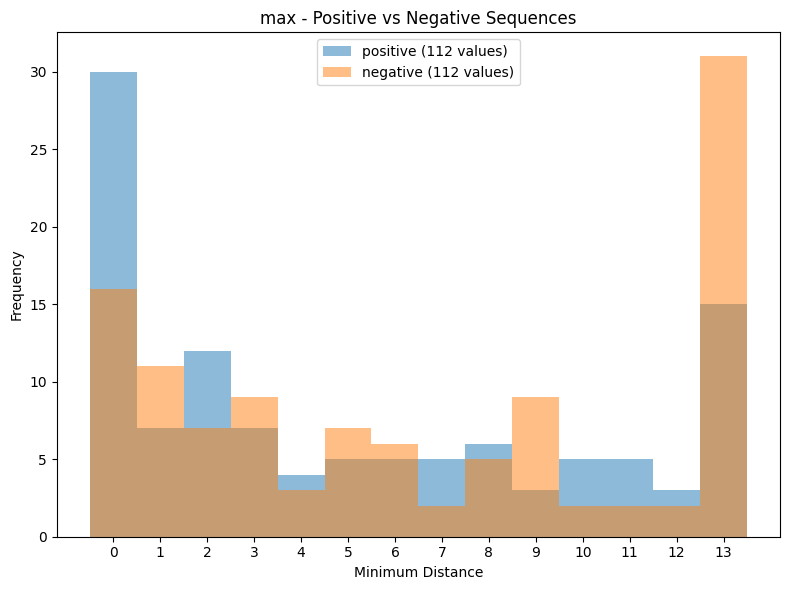

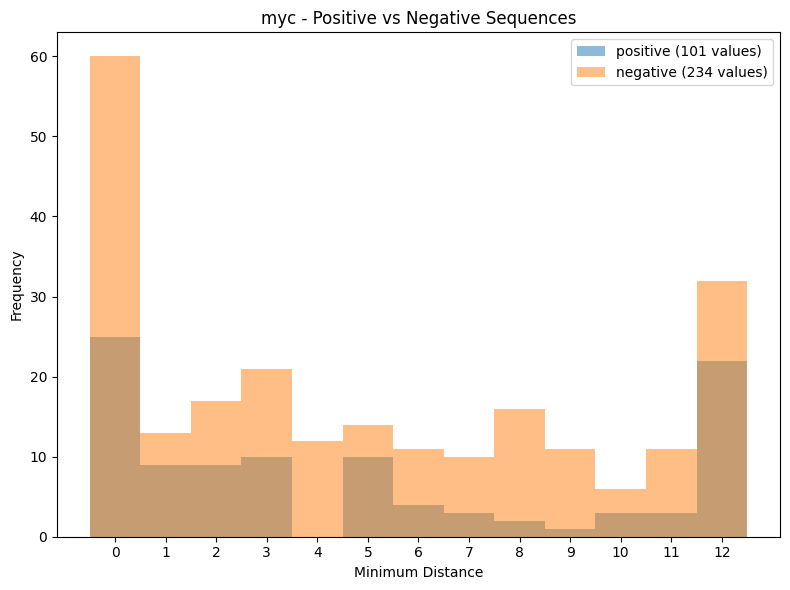

In [44]:
for tf in panset.keys():
    if tf == 'mad':
        continue
    positive_distances = []
    negative_distances = []
    for seq_id_p in positive_sequences[tf]:
        for seq_id in panset[tf].keys():
            if seq_id == seq_id_p:
                positive_distances.append(panset[tf][seq_id]['min_distance'])
    for seq_id_p in negative_sequences[tf]:
        for seq_id in panset[tf].keys():
            if seq_id == seq_id_p:
                negative_distances.append(panset[tf][seq_id]['min_distance'])

    # Calculate the range of values and determine bin edges
    value_range = max(max(positive_distances), max(negative_distances))
    bin_edges = range(0, value_range + 2)  # +2 to include the last integer

    # Create a subplot
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create histograms for positive and negative distances on the same axes
    pos_hist, pos_edges, _ = ax.hist(positive_distances, bins=bin_edges, alpha=0.5, label='positive')
    neg_hist, neg_edges, _ = ax.hist(negative_distances, bins=bin_edges, alpha=0.5, label='negative')

    # Calculate total count of positive and negative data values
    total_pos = int(sum(pos_hist))
    total_neg = int(sum(neg_hist))

    # Add legend with total count annotations
    ax.legend([f'positive ({total_pos} values)', f'negative ({total_neg} values)'])

    ax.set_title(f'{tf} - Positive vs Negative Sequences')
    ax.set_xlabel('Minimum Distance')
    ax.set_ylabel('Frequency')

    # Center-align xticks
    ax.set_xticks([edge + 0.5 for edge in bin_edges[:-1]])
    ax.set_xticklabels([str(int(edge)) for edge in bin_edges[:-1]])

    plt.tight_layout()
    plt.show()


In [45]:
# run a wilcoxon rank sum test on the positive and negative distances
for tf in panset.keys():
    if tf == 'mad':
        continue
    positive_distances = []
    negative_distances = []
    for seq_id_p in positive_sequences[tf]:
        for seq_id in panset[tf].keys():
            if seq_id == seq_id_p:
                positive_distances.append(panset[tf][seq_id]['min_distance'])
    for seq_id_p in negative_sequences[tf]:
        for seq_id in panset[tf].keys():
            if seq_id == seq_id_p:
                negative_distances.append(panset[tf][seq_id]['min_distance'])
    # Perform Wilcoxon rank sum test
    stat, p_value = ranksums(positive_distances, negative_distances)
    
    # Print results
    print(f"TF: {tf}")
    print(f"Wilcoxon Rank Sum Test:")
    print(f"Statistic: {stat}")
    print(f"P-value: {p_value}\n")

TF: max
Wilcoxon Rank Sum Test:
Statistic: -2.4547696266794627
P-value: 0.014097489990475892

TF: myc
Wilcoxon Rank Sum Test:
Statistic: 0.07375706372955367
P-value: 0.941203692102693



In [46]:
thresholds = [2, 3, 4, 5, 6]  # List of 'close' thresholds to test

# Create a dictionary to store p-values for each threshold
p_value_dict = {}
odds_ratio_dict = {}

for threshold in thresholds:
    p_value_dict[threshold] = []
    odds_ratio_dict[threshold] = []

    for tf in panset.keys():
        if tf == 'mad':
            continue
        positive_distances = []
        negative_distances = []

        for seq_id_p in positive_sequences[tf]:
            for seq_id in panset[tf].keys():
                if seq_id == seq_id_p:
                    close = 0
                    if panset[tf][seq_id]['min_distance'] < threshold:
                        close = 1
                    positive_distances.append(close)

        for seq_id_p in negative_sequences[tf]:
            for seq_id in panset[tf].keys():
                if seq_id == seq_id_p:
                    close = 0
                    if panset[tf][seq_id]['min_distance'] < threshold:
                        close = 1
                    negative_distances.append(close)

        # Contingency table
        contingency_table = [[sum(positive_distances), len(positive_distances) - sum(positive_distances)],
                             [sum(negative_distances), len(negative_distances) - sum(negative_distances)]]

        # Perform Fisher's exact test
        odds_ratio, p_value = fisher_exact(contingency_table)

        p_value_dict[threshold].append(p_value)
        odds_ratio_dict[threshold].append(odds_ratio)

# Create a DataFrame to store the p-values for different thresholds, and add thresholds as the header column's name
p_value_df = pd.DataFrame.from_dict(p_value_dict, orient='index', columns=['max', 'myc'])
odds_ratio_df = pd.DataFrame.from_dict(odds_ratio_dict, orient='index', columns=['max', 'myc'])

# Print the DataFrame
print(p_value_df)
print(odds_ratio_df)

        max       myc
2  0.182921  0.702150
3  0.052449  0.543130
4  0.106206  0.407174
5  0.081682  1.000000
6  0.140837  0.545392
        max       myc
2  1.553086  1.119199
3  1.784314  1.186207
4  1.604651  1.223536
5  1.655518  0.996443
6  1.539542  1.173838


In [47]:
# run a fisher exact test on the positive and negative distances
threshold = [2, 3, 4, 5, 6]  # List of 'close' thresholds to test
for limit in threshold:
    for tf in panset.keys():
        if tf == 'mad':
            continue
        positive_distances = []
        negative_distances = []
        for seq_id_p in positive_sequences[tf]:
            for seq_id in panset[tf].keys():
                if seq_id == seq_id_p:
                    close = 0
                    if panset[tf][seq_id]['min_distance'] < limit:
                        close = 1
                    positive_distances.append(close)
        for seq_id_p in negative_sequences[tf]:
            for seq_id in panset[tf].keys():
                if seq_id == seq_id_p:
                    close = 0
                    if panset[tf][seq_id]['min_distance'] < limit:
                        close = 1
                    negative_distances.append(close)
        # Contingency table
        contingency_table = [[sum(positive_distances), len(positive_distances) - sum(positive_distances)], [sum(negative_distances), len(negative_distances) - sum(negative_distances)]]

        # Perform Fisher's exact test
        odds_ratio, p_value = fisher_exact(contingency_table)

        # Print results
        print(f"Threshold: {limit}")
        print(f"TF: {tf}")
        print(f"Contingency Table:")
        print(f"         | Close | Far")
        print(f"Positive |   {sum(positive_distances)}   |   {len(positive_distances) - sum(positive_distances)}")
        print(f"Negative |   {sum(negative_distances)}   |   {len(negative_distances) - sum(negative_distances)}")
        print(f"Odds Ratio: {odds_ratio}")
        print(f"P-value: {p_value}\n")

Threshold: 2
TF: max
Contingency Table:
         | Close | Far
Positive |   37   |   75
Negative |   27   |   85
Odds Ratio: 1.5530864197530865
P-value: 0.1829205247583621

Threshold: 2
TF: myc
Contingency Table:
         | Close | Far
Positive |   34   |   67
Negative |   73   |   161
Odds Ratio: 1.1191985279084031
P-value: 0.7021496365465076

Threshold: 3
TF: max
Contingency Table:
         | Close | Far
Positive |   49   |   63
Negative |   34   |   78
Odds Ratio: 1.7843137254901962
P-value: 0.05244897321111222

Threshold: 3
TF: myc
Contingency Table:
         | Close | Far
Positive |   43   |   58
Negative |   90   |   144
Odds Ratio: 1.186206896551724
P-value: 0.5431296045955182

Threshold: 4
TF: max
Contingency Table:
         | Close | Far
Positive |   56   |   56
Negative |   43   |   69
Odds Ratio: 1.6046511627906976
P-value: 0.10620633889261699

Threshold: 4
TF: myc
Contingency Table:
         | Close | Far
Positive |   53   |   48
Negative |   111   |   123
Odds Ratio: 1.223

In [48]:
# import pandas as pd
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import log_loss
# import numpy as np
# from scipy.stats import norm, chi2

# def perform_linear_regression(data, x_columns, y_column):
#     X = data[x_columns]
#     y = data[y_column]
    
#     model = LinearRegression().fit(X, y)
#     model.fit(X, y)
    
#     return model

# # Loop through the panset dictionary for each TF separately
# data = {}
# models = {}
# summaries = {}

In [49]:
def perform_linear_regression(data, x_columns, y_column):
    X = sm.add_constant(data[x_columns])
    y = data[y_column]

    model = sm.OLS(y, X).fit()
    return model

# Loop through the panset dictionary for each TF separately
data = {}
models = {}
summaries = {}

In [50]:
for tf in panset.keys():
    if tf == 'mad':
        continue
    data[tf] = []
    for seq_id in affinity[tf].keys():
        if seq_id in panset[tf].keys() and panset[tf][seq_id]['strong_motif_binary'] == 0:
            data_point = {
                'bubble_binary': panset[tf][seq_id]['bubble_binary'],
                'binding_affinity': panset[tf][seq_id]['label']
            }

            # Append the data point to the appropriate list based on the presence of motif and bubble
            data[tf].append(data_point)

    # Create pandas DataFrame for each TF
    df = pd.DataFrame(data[tf])

    # Perform linear regression for each case
    model_bubble = perform_linear_regression(df, ['bubble_binary'], 'binding_affinity')

    # Store the models for each TF
    models[tf] = {'bubble_only': model_bubble}

    # store the model summary
    summaries[tf] = calculate_statistics(df[['bubble_binary']], df['binding_affinity'])

In [51]:
# Print the summaries
for tf in summaries.keys():
    print(f"\nTF = {tf}")
    print(summaries[tf].to_markdown())


TF = max
|                       |         Coef. | Std.Err.              | t                  | P>|t|                 | [0.025              | 0.975]              |
|:----------------------|--------------:|:----------------------|:-------------------|:----------------------|:--------------------|:--------------------|
| const                 |   3.99005     | 0.0017679138598285654 | 2256.9270211742746 | 0.0                   | 3.9865868867557808  | 3.993518235955415   |
| bubble_binary         |   0.0634805   | 0.004288707063556005  | 14.801788820759448 | 8.389964716602011e-49 | 0.05507330361235893 | 0.07188776892535179 |
| R-squared             |   0.0317154   |                       |                    |                       |                     |                     |
| F-statistic           | 219.158       |                       |                    |                       |                     |                     |
| P-value (F-statistic) |   1.11022e-16 |                   

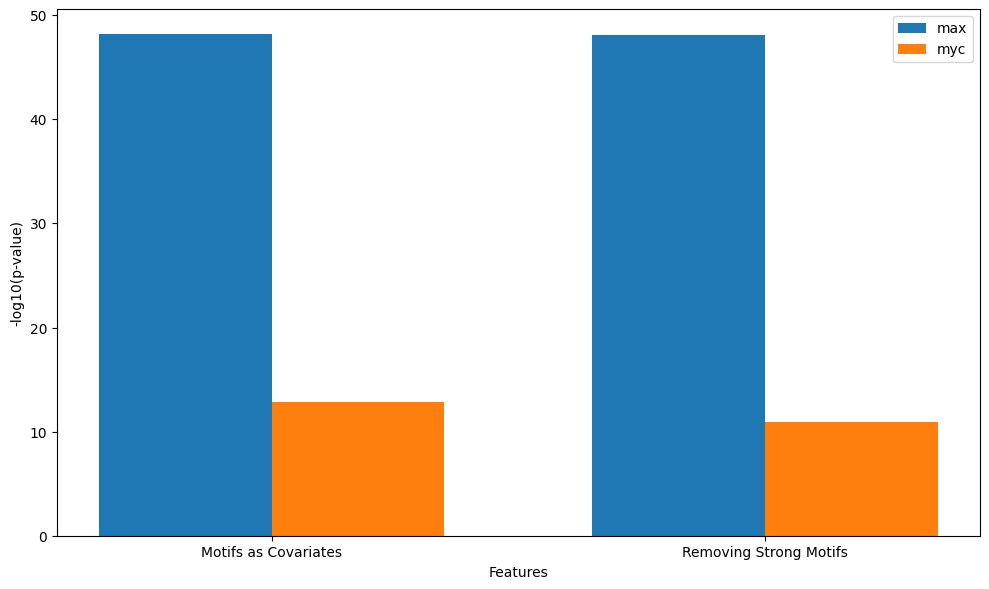

In [52]:
pseudocount = 1e-100

# Define the positions and width for the bars
bar_width = 0.35
positions = np.arange(2)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Add bars for each TF
for i, tf in enumerate(summaries_both.keys()):
    p_values_both = -np.log10([summaries_both[tf].loc['bubble_binary', 'P>|t|'] + pseudocount,
                               summaries[tf].loc['bubble_binary', 'P>|t|'] + pseudocount])
    
    ax.bar(positions + i * bar_width, p_values_both, bar_width, label=tf)

# Set the x-ticks and labels
ax.set_xticks(positions + bar_width / 2)
ax.set_xticklabels([
    'Motifs as Covariates',
    'Removing Strong Motifs'
])

# Set the labels and title
ax.set_xlabel('Features')
ax.set_ylabel('-log10(p-value)')
# ax.set_title('Negative Log10 of p-values for Coefficients in Linear Regression Models')

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.savefig('/scratch/midway3/waqaas/DNA-breathing/figs/paper/motif_bubble_p_values.png')
plt.show()


In [53]:
for tf in panset.keys():
    if tf == 'mad':
        continue
    for seq_id in panset[tf].keys():
        flip = []
        coord = []
        coordsq = []
        for i in range(36):
            if panset[tf][seq_id]['motif_seq'][i] == 1:
                flip.append(panset[tf][seq_id]['flipping'][i])
                coord.append(panset[tf][seq_id]['coords'][i])
                coordsq.append(panset[tf][seq_id]['coordssquared'][i])
            else:
                flip.append(0)
                coord.append(0)
                coordsq.append(0)
        # append the average feature value to the dictionary
        panset[tf][seq_id]['motif_flip'] = sum(flip) / len(flip)
        panset[tf][seq_id]['motif_coord'] = sum(coord) / len(coord)
        panset[tf][seq_id]['motif_coordsq'] = sum(coordsq) / len(coordsq)

In [54]:
for seq_id in panset['max'].keys():
    print(panset['max'][seq_id].keys())
    break

dict_keys(['seq', 'label', 'bubble', 'flipping', 'coords', 'coordssquared', 'bubble_binary', 'motif_seq_positive', 'motif_seq_negative', 'motif_seq', 'p-value_positive', 'p-value_negative', 'strong_motif_binary', 'weak_motif_binary', 'bubble_seq', 'strong_motif_and_bubble_binary', 'weak_motif_and_bubble_binary', 'motif_and_bubble_binary', 'motif_flip', 'motif_coord', 'motif_coordsq'])


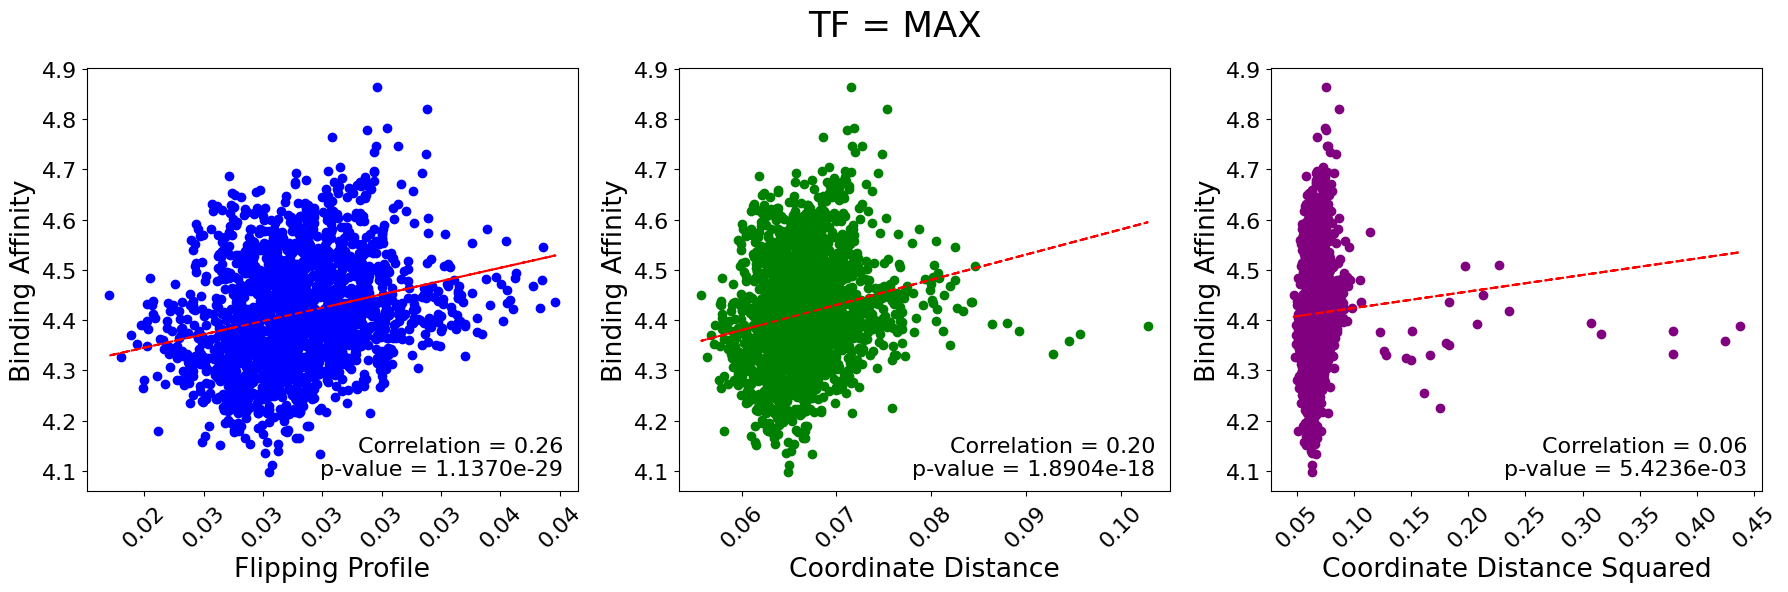

<Figure size 640x480 with 0 Axes>

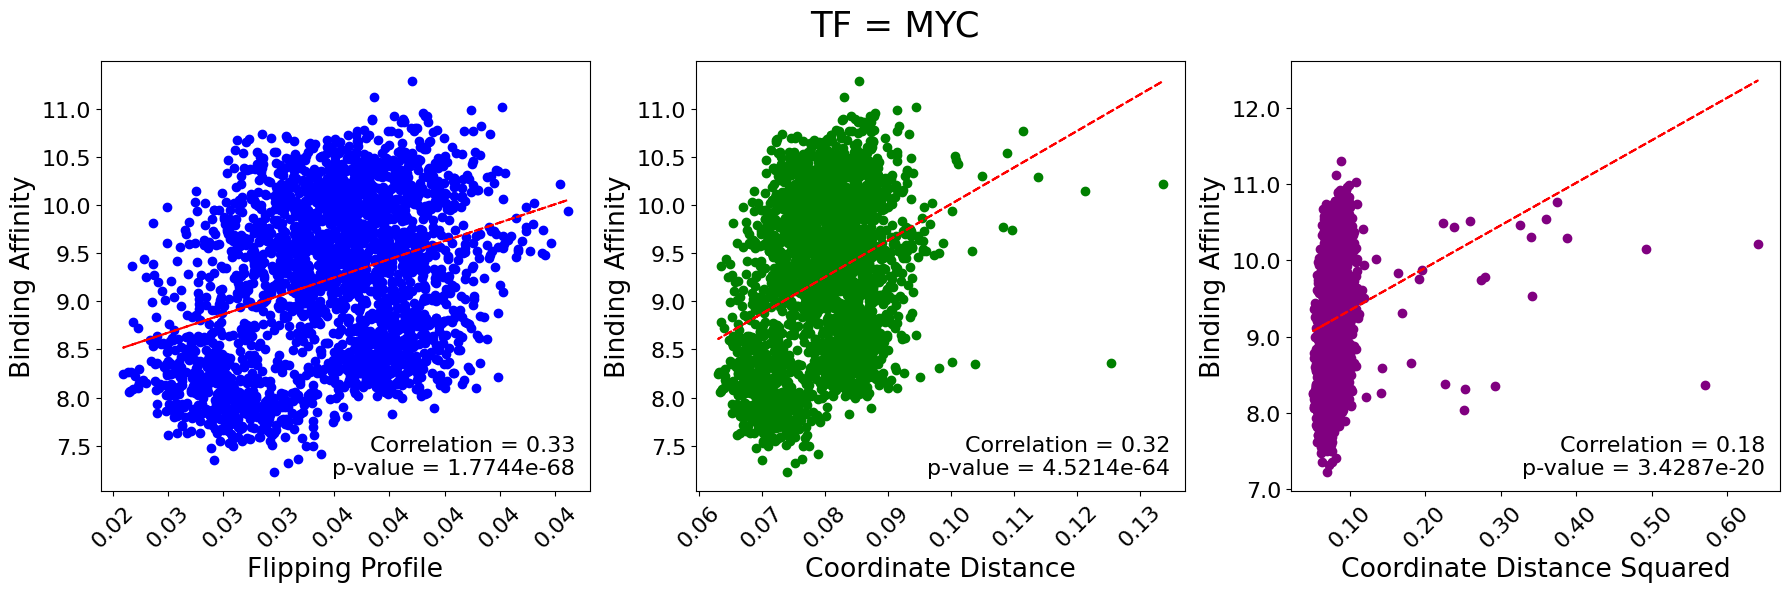

<Figure size 640x480 with 0 Axes>

In [58]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from matplotlib.ticker import FormatStrFormatter

correlation_results = {}

for tf in panset.keys():
    if tf == 'mad':
        continue

    motif_flip = []
    motif_coord = []
    motif_coordsq = []
    binding_affinity = []  # Labels

    for seq_id in panset[tf].keys():
        if panset[tf][seq_id]['strong_motif_binary'] == 1:
            motif_flip.append(panset[tf][seq_id]['motif_flip'])
            motif_coord.append(panset[tf][seq_id]['motif_coord'])
            motif_coordsq.append(panset[tf][seq_id]['motif_coordsq'])
            binding_affinity.append(panset[tf][seq_id]['label'])

    # Calculate Pearson correlation coefficients and p-values
    corr_flip, p_value_flip = pearsonr(motif_flip, binding_affinity)
    corr_coord, p_value_coord = pearsonr(motif_coord, binding_affinity)
    corr_coordsq, p_value_coordsq = pearsonr(motif_coordsq, binding_affinity)

    correlation_results[tf] = {
        'motif_flip': (corr_flip, p_value_flip),
        'motif_coord': (corr_coord, p_value_coord),
        'motif_coordsq': (corr_coordsq, p_value_coordsq),
    }

    a = 1.6
    # Increase font size by a factor of a for titles, labels, text, and ticks
    title_fontsize = 16 * a
    label_fontsize = 12 * a
    text_fontsize = 10 * a
    tick_fontsize = 8 * 2  # Adjust tick font size

    # Formatters for ticks
    x_formatter = FormatStrFormatter('%.2f')  # 4 decimal places for x-axis
    y_formatter = FormatStrFormatter('%.1f')  # 1 decimal place for y-axis

    # Create scatterplots with lines of best fit
    plt.figure(figsize=(18, 6))
    plt.suptitle('TF = ' + f'{tf}'.upper(), fontsize=title_fontsize)

    # First subplot
    plt.subplot(131)
    plt.scatter(motif_flip, binding_affinity, color="blue")
    m, b = np.polyfit(motif_flip, binding_affinity, 1)
    plt.plot(motif_flip, m * np.array(motif_flip) + b, color='red', linestyle='--')
    plt.xlabel(f'Flipping Profile', fontsize=label_fontsize)
    plt.ylabel('Binding Affinity', fontsize=label_fontsize)
    plt.xticks(fontsize=tick_fontsize, rotation=45)
    plt.yticks(fontsize=tick_fontsize)
    plt.gca().xaxis.set_major_formatter(x_formatter)
    plt.gca().yaxis.set_major_formatter(y_formatter)
    # Use plt.text to display correlation and p-value
    plt.text(0.97, 0.03, f'Correlation = {corr_flip:.2f}\np-value = {p_value_flip:.4e}', transform=plt.gca().transAxes, horizontalalignment='right', verticalalignment='bottom', fontsize=text_fontsize)

    # Second subplot
    plt.subplot(132)
    plt.scatter(motif_coord, binding_affinity, color='green')
    m, b = np.polyfit(motif_coord, binding_affinity, 1)
    plt.plot(motif_coord, m * np.array(motif_coord) + b, color='red', linestyle='--')
    plt.xlabel(f'Coordinate Distance', fontsize=label_fontsize)
    plt.ylabel('Binding Affinity', fontsize=label_fontsize)
    plt.xticks(fontsize=tick_fontsize, rotation=45)
    plt.yticks(fontsize=tick_fontsize)
    plt.gca().xaxis.set_major_formatter(x_formatter)
    plt.gca().yaxis.set_major_formatter(y_formatter)
    # Use plt.text to display correlation and p-value
    plt.text(0.97, 0.03, f'Correlation = {corr_coord:.2f}\np-value = {p_value_coord:.4e}', transform=plt.gca().transAxes, horizontalalignment='right', verticalalignment='bottom', fontsize=text_fontsize)

    # Third subplot
    plt.subplot(133)
    plt.scatter(motif_coordsq, binding_affinity, color='purple')
    m, b = np.polyfit(motif_coordsq, binding_affinity, 1)
    plt.plot(motif_coordsq, m * np.array(motif_coordsq) + b, color='red', linestyle='--')
    plt.xlabel(f'Coordinate Distance Squared', fontsize=label_fontsize)
    plt.ylabel('Binding Affinity', fontsize=label_fontsize)
    plt.xticks(fontsize=tick_fontsize, rotation=45)
    plt.yticks(fontsize=tick_fontsize)
    plt.gca().xaxis.set_major_formatter(x_formatter)
    plt.gca().yaxis.set_major_formatter(y_formatter)
    # Use plt.text to display correlation and p-value
    plt.text(0.97, 0.03, f'Correlation = {corr_coordsq:.2f}\np-value = {p_value_coordsq:.4e}', transform=plt.gca().transAxes, horizontalalignment='right', verticalalignment='bottom', fontsize=text_fontsize)

    plt.tight_layout()
    plt.savefig(f'/scratch/midway3/waqaas/DNA-breathing/figs/paper/{tf}_correlation.png')
    plt.show()

    # Clear the figure to create a new one for the next TF
    plt.clf()


In [59]:
for tf in panset.keys():
    if tf == 'mad':
        continue
    count = []
    for seq_id in panset[tf].keys():
        count.append(sum(panset[tf][seq_id]['motif_seq']))
    # display unique counts and their frequencies
    unique, counts = np.unique(count, return_counts=True)
    print(dict(zip(unique, counts)))

{0.0: 1340, 10.0: 7228}
{0.0: 1009, 12.0: 5917}


In [60]:
for tf in panset.keys():
    if tf == 'mad':
        continue
    count = 0
    for seq_id in panset[tf].keys():
        if panset[tf][seq_id]['strong_motif_binary'] == 1:
            # count the number of ones in 'motif_seq'
            count = sum(panset[tf][seq_id]['motif_seq'])
    for i in range(int(count)):
        for seq_id in panset[tf].keys():
            if panset[tf][seq_id]['strong_motif_binary'] == 1:
                temp = {}
                temp[f'motif_flip_{i}'] = []
                temp[f'motif_coord_{i}'] = []
                temp[f'motif_coordsq_{i}'] = []
                if sum(panset[tf][seq_id]['motif_seq_positive']) != 0:
                    for j in range(36):
                        if panset[tf][seq_id]['motif_seq_positive'][j] == 1:
                            k = j + i
                            temp[f'motif_flip_{i}'].append(panset[tf][seq_id]['flipping'][k])
                            temp[f'motif_coord_{i}'].append(panset[tf][seq_id]['coords'][k])
                            temp[f'motif_coordsq_{i}'].append(panset[tf][seq_id]['coordssquared'][k])
                            break
                if sum(panset[tf][seq_id]['motif_seq_negative']) != 0:
                    # reverse countdown from 35 to 0
                    for j in range(35, -1, -1):
                        if panset[tf][seq_id]['motif_seq_negative'][j] == 1:
                            k = j - i
                            temp[f'motif_flip_{i}'].append(panset[tf][seq_id]['flipping'][k])
                            temp[f'motif_coord_{i}'].append(panset[tf][seq_id]['coords'][k])
                            temp[f'motif_coordsq_{i}'].append(panset[tf][seq_id]['coordssquared'][k])
                            break
                panset[tf][seq_id][f'motif_flip_{i}'] = sum(temp[f'motif_flip_{i}']) / len(temp[f'motif_flip_{i}'])
                panset[tf][seq_id][f'motif_coord_{i}'] = sum(temp[f'motif_coord_{i}']) / len(temp[f'motif_coord_{i}'])
                panset[tf][seq_id][f'motif_coordsq_{i}'] = sum(temp[f'motif_coordsq_{i}']) / len(temp[f'motif_coordsq_{i}'])

In [56]:
# correlation_data = {}

# for tf in panset.keys():
#     if tf == 'mad':
#         continue
#     correlation_data[tf] = {}
#     count = 0
#     for seq_id in panset[tf].keys():
#         if panset[tf][seq_id]['strong_motif_binary'] == 1:
#             # Count the number of ones in 'motif_seq'
#             count = sum(panset[tf][seq_id]['motif_seq'])
#     bar_graph = {}
#     for i in range(int(count)):
#         bar_graph[i] = {}
#         for feature in ['flip', 'coord', 'coordsq']:
#             correlation_data[tf][feature] = []
#         correlation_data[tf]['label_values'] = []
#         for seq_id in panset[tf].keys():
#             if panset[tf][seq_id]['strong_motif_binary'] == 1:
#                 for feature in ['flip', 'coord', 'coordsq']:
#                     correlation_data[tf][feature].append(panset[tf][seq_id][f'motif_{feature}_{i}'])
#                 correlation_data[tf]['label_values'].append(panset[tf][seq_id]['label'])

#         # Use correlation_data to calculate pearson correlation coefficients and p-values for each feature
#         for feature in ['flip', 'coord', 'coordsq']:
#             corr, p_value = pearsonr(correlation_data[tf][feature], correlation_data[tf]['label_values'])
#             bar_graph[i][feature] = {'p_value': p_value, 'correlation': corr}
#             print(f"\nTF = {tf}")
#             print(f"Pearson Correlation with Motif {feature} Feature: Correlation = {corr:.2f}, p-value = {p_value:.2e}")

#     # Create a bar graph for each feature: correlation vs. position (i) and -log10(p-value) vs. position (i)
#     for feature in ['flip', 'coord', 'coordsq']:
#         positions = list(bar_graph.keys())
#         correlations = [entry[feature]['correlation'] for entry in bar_graph.values()]
#         p_values = [-np.log10(entry[feature]['p_value']) for entry in bar_graph.values()]  # Take the negative log10 of p-values

#         plt.figure(figsize=(6, 6))
#         # add title
#         plt.suptitle(f'{tf} - Motif {feature} Feature vs Binding Affinity')

#         plt.subplot(121)
#         plt.bar(positions, correlations)
#         plt.xlabel('Position (i)')
#         plt.ylabel('Correlation')
#         plt.title(f'{feature}')
#         plt.xticks(positions, positions)  # Add numerical x-ticks

#         plt.subplot(122)
#         plt.bar(positions, p_values)
#         plt.xlabel('Position (i)')
#         plt.ylabel('-log10(p-value)')  # Change the y-axis label
#         plt.title(f'-log10(p-value)')
#         plt.grid(axis='y')
#         plt.xticks(positions, positions)  # Add numerical x-ticks

#         plt.tight_layout()
#         plt.show()


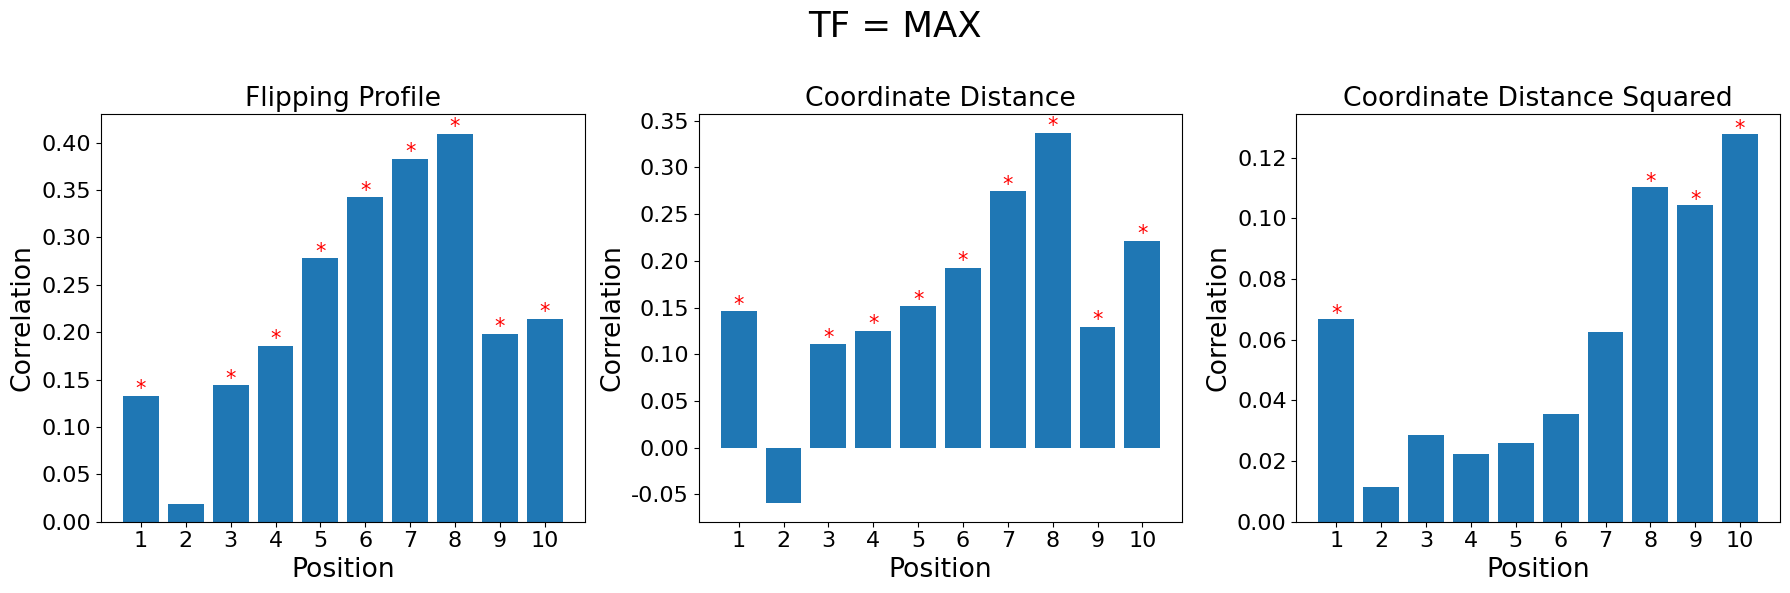

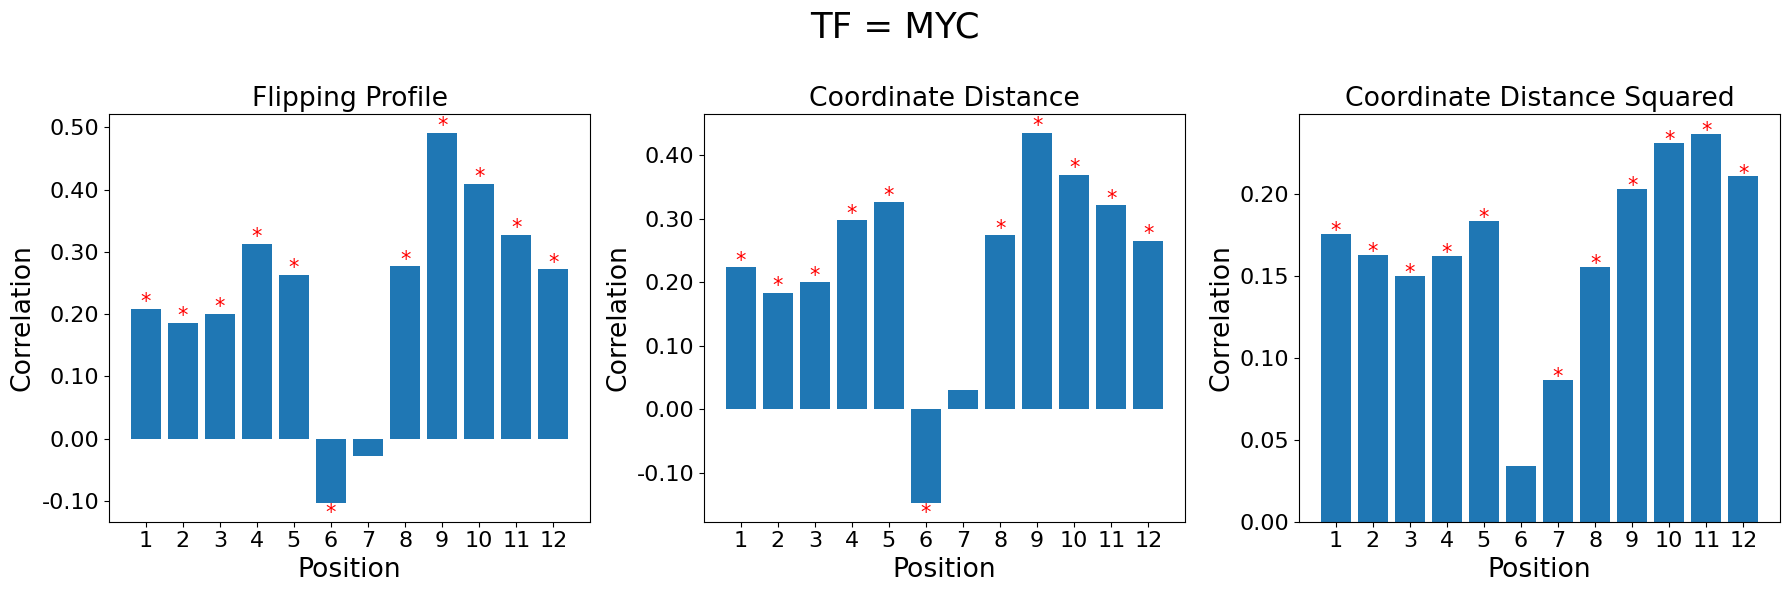

In [71]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib.ticker import FormatStrFormatter

correlation_data = {}

for tf in panset.keys():
    if tf == 'mad':
        continue
    correlation_data[tf] = {}
    count = 0
    for seq_id in panset[tf].keys():
        if panset[tf][seq_id]['strong_motif_binary'] == 1:
            # Count the number of ones in 'motif_seq'
            count = sum(panset[tf][seq_id]['motif_seq'])
    bar_graph = {}
    for i in range(int(count)):
        bar_graph[i] = {}
        for feature in ['flip', 'coord', 'coordsq']:
            correlation_data[tf][feature] = []
        correlation_data[tf]['label_values'] = []
        for seq_id in panset[tf].keys():
            if panset[tf][seq_id]['strong_motif_binary'] == 1:
                for feature in ['flip', 'coord', 'coordsq']:
                    correlation_data[tf][feature].append(panset[tf][seq_id][f'motif_{feature}_{i}'])
                correlation_data[tf]['label_values'].append(panset[tf][seq_id]['label'])

        # Use correlation_data to calculate pearson correlation coefficients and p-values for each feature
        for feature in ['flip', 'coord', 'coordsq']:
            corr, p_value = pearsonr(correlation_data[tf][feature], correlation_data[tf]['label_values'])
            bar_graph[i][feature] = {'p_value': p_value, 'correlation': corr}

    # Create a figure with three horizontal panels for each feature
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('TF = ' + f'{tf}'.upper(), fontsize=16 * 1.6)

    for ax, feature in zip(axes, ['flip', 'coord', 'coordsq']):
        positions = list(bar_graph.keys())
        correlations = [entry[feature]['correlation'] for entry in bar_graph.values()]
        p_values = [entry[feature]['p_value'] for entry in bar_graph.values()]

        ax.bar(positions, correlations)
        ax.set_xlabel('Position', fontsize=12 * 1.6)
        ax.set_ylabel('Correlation', fontsize=12 * 1.6)

        # Format y-ticks to two decimal places
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

        if feature == 'flip':
            ax.set_title('Flipping Profile', fontsize=12 * 1.6)
        elif feature == 'coord':
            ax.set_title('Coordinate Distance', fontsize=12 * 1.6)
        else:
            ax.set_title('Coordinate Distance Squared', fontsize=12 * 1.6)
        ax.set_xticks(positions)
        ax.set_xticklabels([o + 1 for o in positions], fontsize=8 * 2)
        ax.tick_params(axis='y', labelsize=8 * 2)

        # Calculate the corrected alpha for significance testing
        corrected_alpha = 0.05 / (i + 1)

        for j, p_value in enumerate(p_values):
            if p_value < corrected_alpha:
                if correlations[j] < 0:
                    ax.text(positions[j], correlations[j], '*', ha='center', va='top', size=15, color='red')
                else:
                    ax.text(positions[j], correlations[j] - (correlations[0]/40), '*', ha='center', va='bottom', size=15, color='red')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'/scratch/midway3/waqaas/DNA-breathing/figs/paper/{tf}_motif_features.png')
    plt.show()

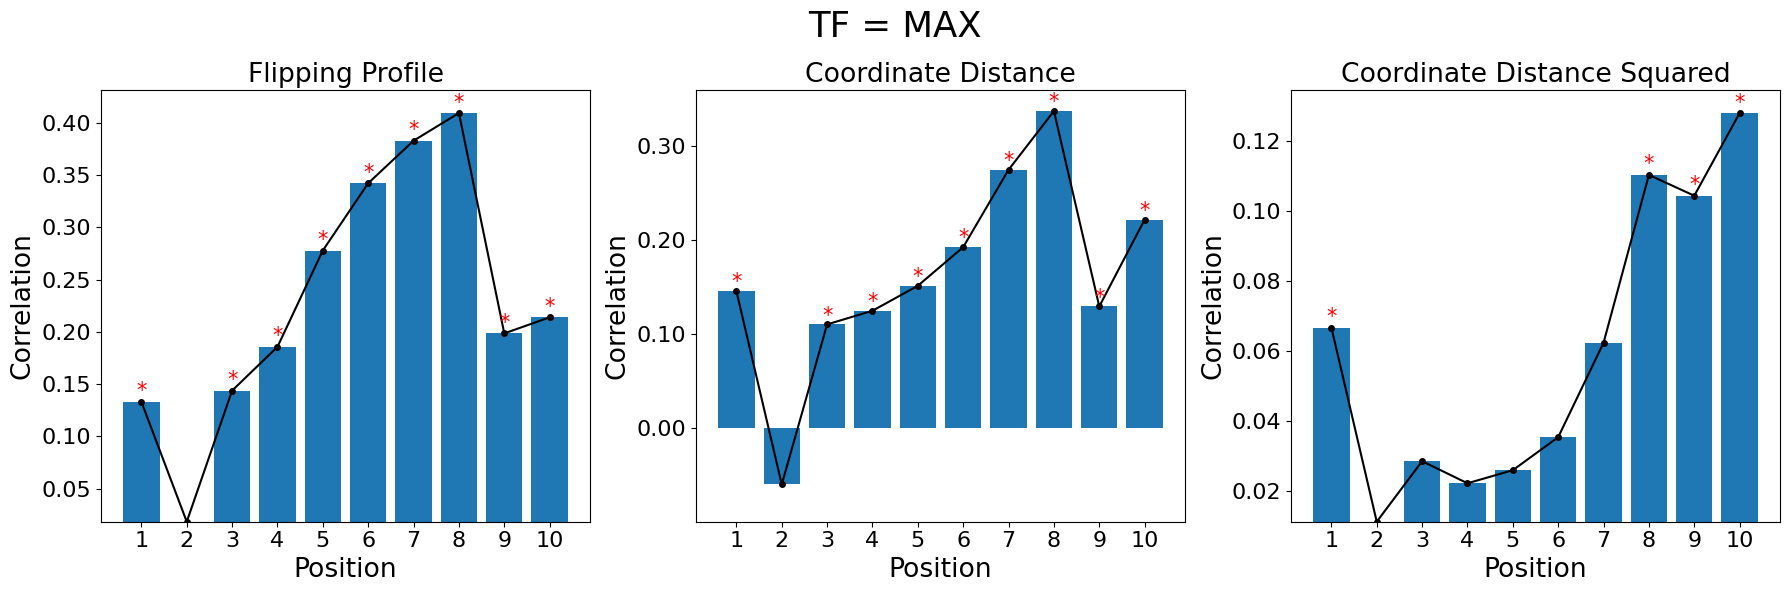

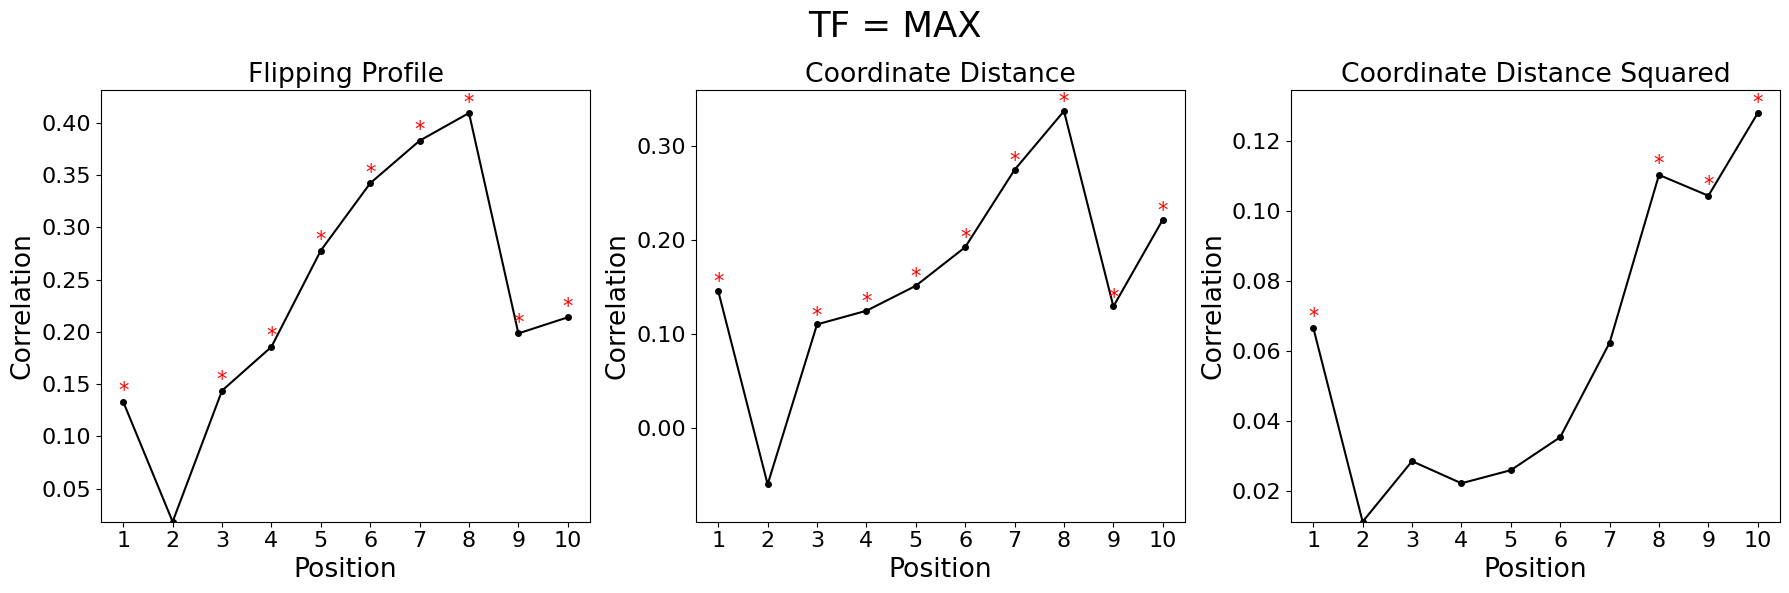

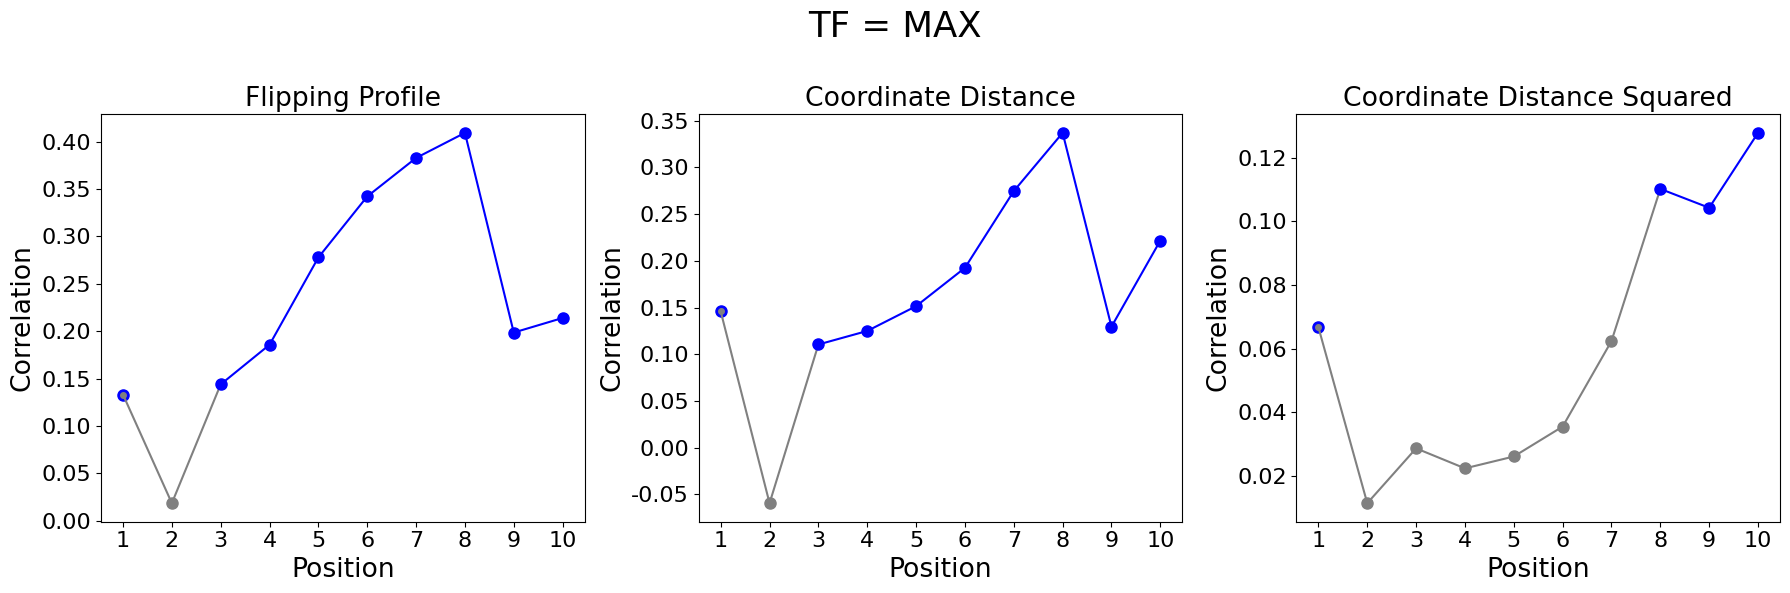

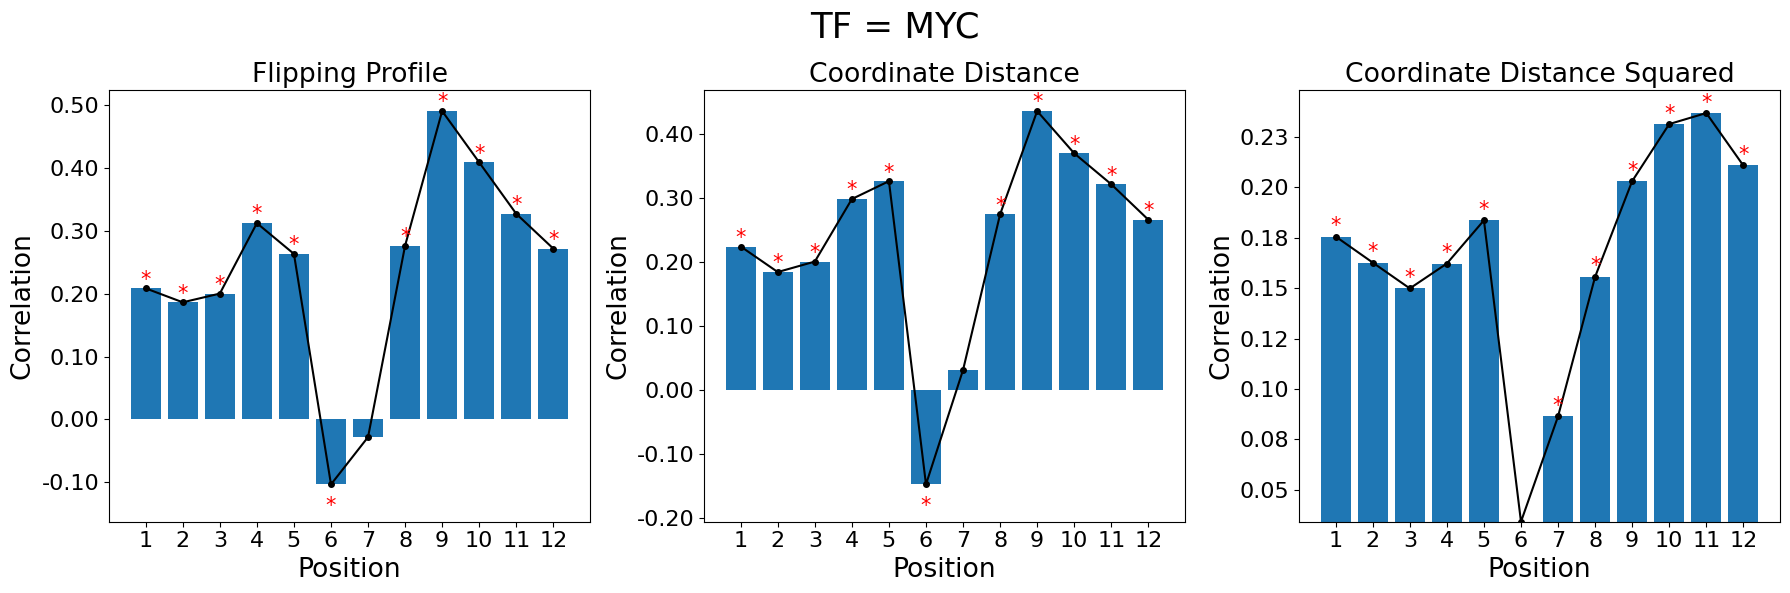

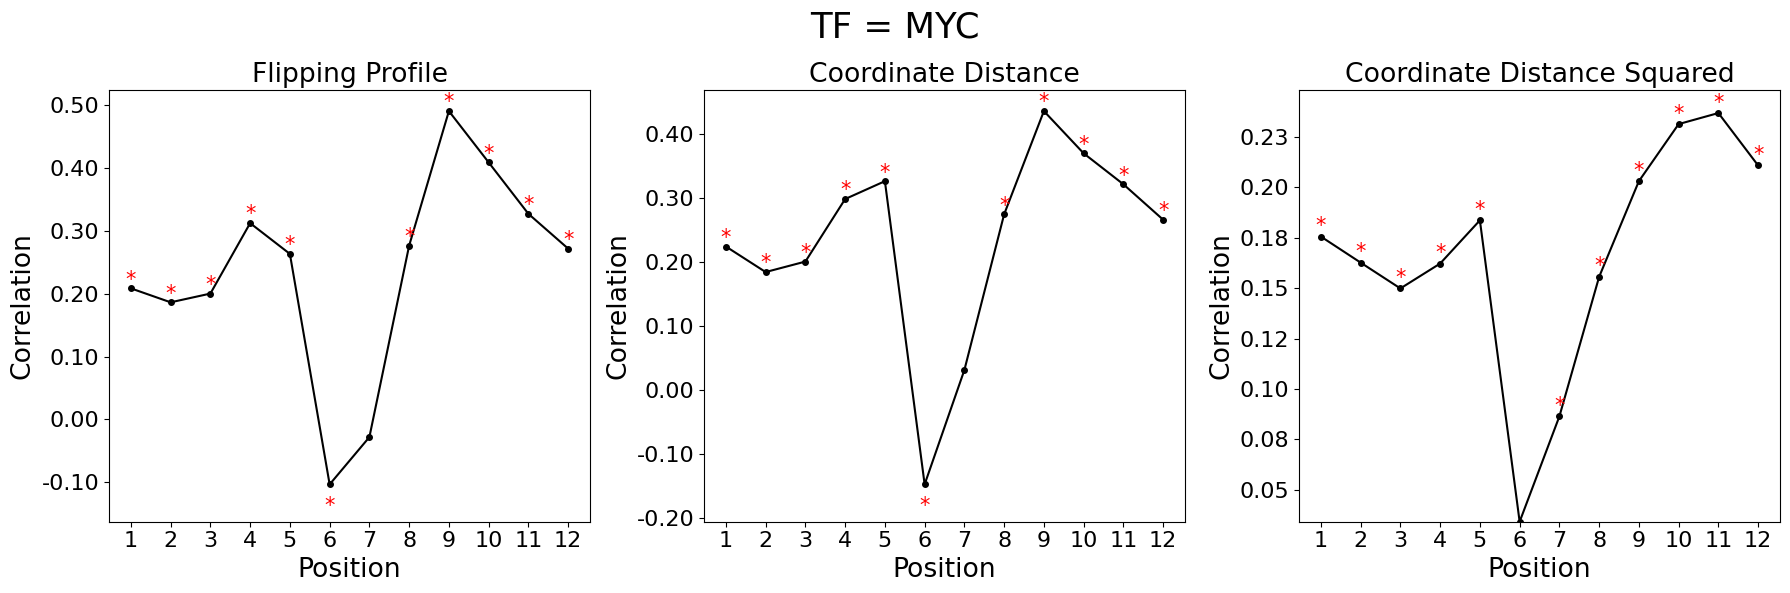

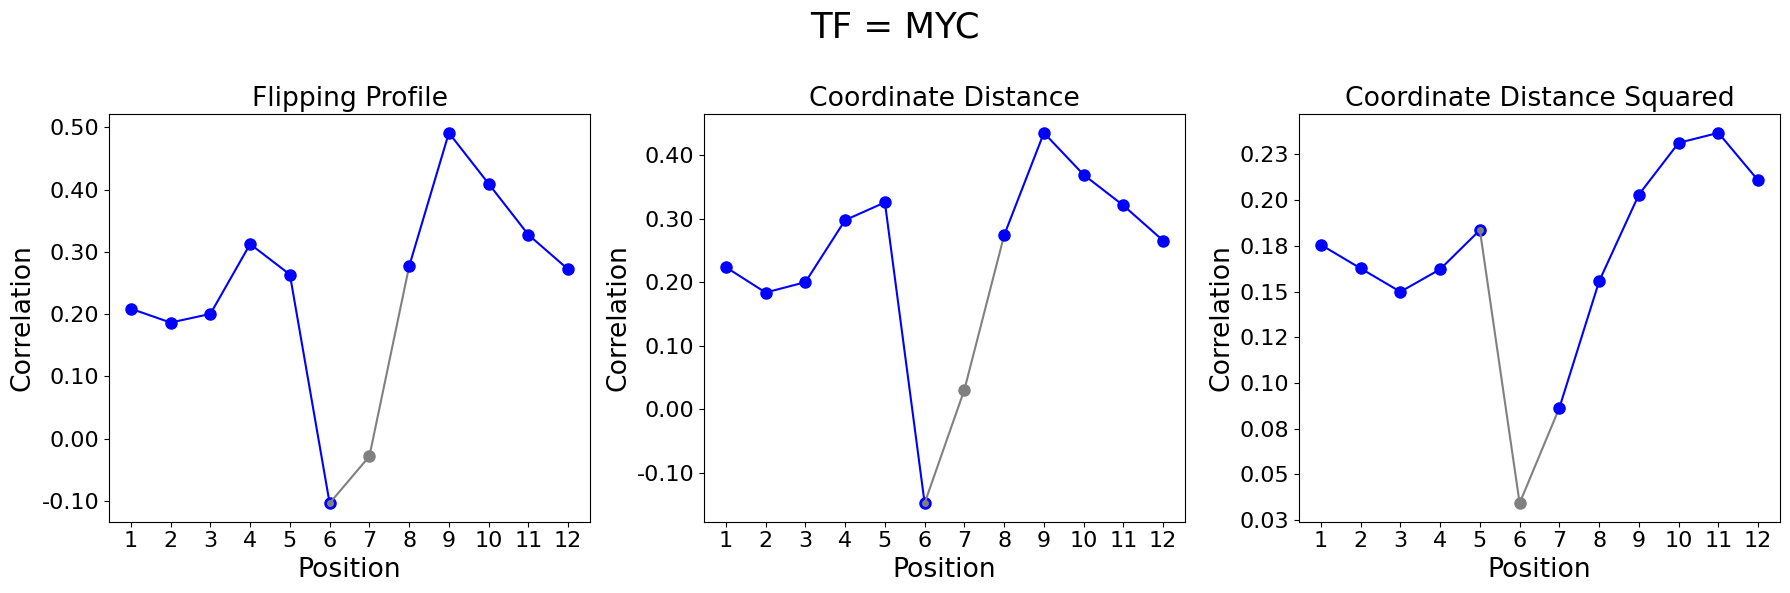

In [88]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from matplotlib.ticker import FormatStrFormatter

def extend_y_limits(ax, correlations, sizer):
    max_corr = max(correlations) + abs(sizer/18)
    if min(correlations) < 0:
        min_corr = min(correlations) - abs(sizer/10)
    else:
        min_corr = min(correlations)
    ax.set_ylim(min_corr, max_corr)

def create_bar_and_lineplot(bar_graph, tf, save_path):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('TF = ' + f'{tf}'.upper(), fontsize=16 * 1.6)

    for ax, feature in zip(axes, ['flip', 'coord', 'coordsq']):
        positions = list(bar_graph.keys())
        correlations = [entry[feature]['correlation'] for entry in bar_graph.values()]
        p_values = [entry[feature]['p_value'] for entry in bar_graph.values()]

        ax.bar(positions, correlations)
        ax.plot(positions, correlations, color='black', marker='o', linestyle='-', markersize=4)
        ax.set_xlabel('Position', fontsize=12 * 1.6)
        ax.set_ylabel('Correlation', fontsize=12 * 1.6)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Y-ticks with 2 decimal places

        if feature == 'flip':
            ax.set_title('Flipping Profile', fontsize=12 * 1.6)
        elif feature == 'coord':
            ax.set_title('Coordinate Distance', fontsize=12 * 1.6)
        else:
            ax.set_title('Coordinate Distance Squared', fontsize=12 * 1.6)

        ax.set_xticks(positions)
        ax.set_xticklabels([o + 1 for o in positions], fontsize=8 * 2)
        ax.tick_params(axis='y', labelsize=8 * 2)

        corrected_alpha = 0.05 / len(positions)  # Corrected alpha for significance testing
        sizer = correlations[max(range(len(correlations)), key=lambda i: abs(correlations[i]))] - correlations[min(range(len(correlations)), key=lambda i: (correlations[i]))]

        # Extend y-axis limits to fit the asterisks
        extend_y_limits(ax, correlations, sizer)

        for j, p_value in enumerate(p_values):
            if p_value < corrected_alpha:
                if correlations[j] > 0:
                    ax.text(positions[j], correlations[j] + abs(sizer/20), '*', ha='center', va='top', size=15, color='red')
                else:
                    ax.text(positions[j], correlations[j] - abs(sizer/12), '*', ha='center', va='bottom', size=15, color='red')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

def create_lineplot(bar_graph, tf, save_path):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('TF = ' + f'{tf}'.upper(), fontsize=16 * 1.6)

    for ax, feature in zip(axes, ['flip', 'coord', 'coordsq']):
        positions = list(bar_graph.keys())
        correlations = [entry[feature]['correlation'] for entry in bar_graph.values()]
        p_values = [entry[feature]['p_value'] for entry in bar_graph.values()]

        ax.plot(positions, correlations, color='black', marker='o', linestyle='-', markersize=4)
        ax.set_xlabel('Position', fontsize=12 * 1.6)
        ax.set_ylabel('Correlation', fontsize=12 * 1.6)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Y-ticks with 2 decimal places

        if feature == 'flip':
            ax.set_title('Flipping Profile', fontsize=12 * 1.6)
        elif feature == 'coord':
            ax.set_title('Coordinate Distance', fontsize=12 * 1.6)
        else:
            ax.set_title('Coordinate Distance Squared', fontsize=12 * 1.6)

        ax.set_xticks(positions)
        ax.set_xticklabels([o + 1 for o in positions], fontsize=8 * 2)
        ax.tick_params(axis='y', labelsize=8 * 2)

        corrected_alpha = 0.05 / len(positions)  # Corrected alpha for significance testing
        sizer = correlations[max(range(len(correlations)), key=lambda i: abs(correlations[i]))] - correlations[min(range(len(correlations)), key=lambda i: (correlations[i]))]

        # Extend y-axis limits to fit the asterisks
        extend_y_limits(ax, correlations, sizer)

        for j, p_value in enumerate(p_values):
            if p_value < corrected_alpha:
                if correlations[j] > 0:
                    ax.text(positions[j], correlations[j] + abs(sizer/20), '*', ha='center', va='top', size=15, color='red')
                else:
                    ax.text(positions[j], correlations[j] - abs(sizer/12), '*', ha='center', va='bottom', size=15, color='red')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

def create_color_coded_lineplot(bar_graph, tf, save_path):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('TF = ' + f'{tf}'.upper(), fontsize=16 * 1.6)

    for ax, feature in zip(axes, ['flip', 'coord', 'coordsq']):
        positions = list(bar_graph.keys())
        correlations = [entry[feature]['correlation'] for entry in bar_graph.values()]
        p_values = [entry[feature]['p_value'] for entry in bar_graph.values()]

        corrected_alpha = 0.05 / len(positions)  # Corrected alpha for significance testing

        # Plot color-coded lineplot
        for j in range(len(positions)):
            if j > 0:
                if p_values[j-1] < corrected_alpha and p_values[j] < corrected_alpha:
                    color = 'blue'
                else:
                    color = 'grey'
                ax.plot([positions[j-1], positions[j]], [correlations[j-1], correlations[j]], color=color, marker='o', markersize=4)

            # Draw the marker for the current position
            marker_color = 'blue' if p_values[j] < corrected_alpha else 'grey'
            ax.plot([positions[j]], [correlations[j]], color=marker_color, marker='o', markersize=8)

        ax.set_xlabel('Position', fontsize=12 * 1.6)
        ax.set_ylabel('Correlation', fontsize=12 * 1.6)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Y-ticks with 2 decimal places

        if feature == 'flip':
            ax.set_title('Flipping Profile', fontsize=12 * 1.6)
        elif feature == 'coord':
            ax.set_title('Coordinate Distance', fontsize=12 * 1.6)
        else:
            ax.set_title('Coordinate Distance Squared', fontsize=12 * 1.6)

        ax.set_xticks(positions)
        ax.set_xticklabels([o + 1 for o in positions], fontsize=8 * 2)
        ax.tick_params(axis='y', labelsize=8 * 2)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(save_path)
    plt.show()


# Example of how to call these functions
for tf in panset.keys():
    if tf == 'mad':
        continue

    bar_graph = {}
    for seq_id in panset[tf].keys():
        if panset[tf][seq_id]['strong_motif_binary'] == 1:
            count = sum(panset[tf][seq_id]['motif_seq'])

    for i in range(int(count)):
        bar_graph[i] = {}
        for feature in ['flip', 'coord', 'coordsq']:
            correlation_data[tf][feature] = []
        correlation_data[tf]['label_values'] = []
        for seq_id in panset[tf].keys():
            if panset[tf][seq_id]['strong_motif_binary'] == 1:
                for feature in ['flip', 'coord', 'coordsq']:
                    correlation_data[tf][feature].append(panset[tf][seq_id][f'motif_{feature}_{i}'])
                correlation_data[tf]['label_values'].append(panset[tf][seq_id]['label'])

        for feature in ['flip', 'coord', 'coordsq']:
            corr, p_value = pearsonr(correlation_data[tf][feature], correlation_data[tf]['label_values'])
            bar_graph[i][feature] = {'p_value': p_value, 'correlation': corr}

    # Generate the figures for each TF
    create_bar_and_lineplot(bar_graph, tf, f'/scratch/midway3/waqaas/DNA-breathing/figs/paper/{tf}_bar_lineplot.png')
    create_lineplot(bar_graph, tf, f'/scratch/midway3/waqaas/DNA-breathing/figs/paper/{tf}_lineplot.png')
    create_color_coded_lineplot(bar_graph, tf, f'/scratch/midway3/waqaas/DNA-breathing/figs/paper/{tf}_color_coded_lineplot.png')


In [58]:
# for each tf, using only the sequences where weak_motif_binary = 1, do a logistic regression with the bubble feature against the label
for tf in panset.keys():
    if tf == 'mad':
        continue
    data[tf] = []
    for seq_id in affinity[tf].keys():
        if seq_id in panset[tf].keys() and panset[tf][seq_id]['weak_motif_binary'] == 1:
            data_point = {
                'bubble_binary': panset[tf][seq_id]['bubble_binary'],
                'binding_affinity': panset[tf][seq_id]['label']
            }

        # Append the data point to the appropriate list based on the presence of motif and bubble
            data[tf].append(data_point)

    # Create pandas DataFrame for each TF
    df = pd.DataFrame(data[tf])

    # Perform linear regression for each case
    model_bubble = perform_linear_regression(df, ['bubble_binary'], 'binding_affinity')

    # Store the models for each TF
    models[tf] = {'bubble_only': model_bubble}

    # store the model summary
    summaries[tf] = calculate_statistics(df[['bubble_binary']], df['binding_affinity'])

In [59]:
# print the summaries
for tf in summaries.keys():
    print(f"\nTF = {tf}")
    print(summaries[tf].to_markdown())


TF = max
|                       |         Coef. | Std.Err.              | t                  | P>|t|                  | [0.025               | 0.975]              |
|:----------------------|--------------:|:----------------------|:-------------------|:-----------------------|:---------------------|:--------------------|
| const                 |   4.00508     | 0.0020656900585463464 | 1938.8583091048033 | 0.0                    | 4.001030739596412    | 4.009129928499131   |
| bubble_binary         |   0.0699178   | 0.005000889358099855  | 13.98108277210061  | 1.1836669873156899e-43 | 0.060114066638925295 | 0.07972162946049702 |
| R-squared             |   0.0352551   |                       |                    |                        |                      |                     |
| F-statistic           | 195.544       |                       |                    |                        |                      |                     |
| P-value (F-statistic) |   1.11022e-16 |       

In [60]:
# pick the top x% of sequences with highest affinity (weak edition)
x = 0.125
positive_sequences_w = {}
negative_sequences_w = {}
for tf in panset.keys():
    if tf == 'mad':
        continue
    positive_sequences_w[tf] = []
    negative_sequences_w[tf] = []
    total_seq_count = len(highest_affinity[tf])
    top_x_percent = int(total_seq_count * x)
    rest_of_sequences = total_seq_count - top_x_percent
    for n, seq_id_p in enumerate(highest_affinity[tf]):
        if n < top_x_percent:
            for seq_id in panset[tf].keys():
                if seq_id_p[0] == seq_id and panset[tf][seq_id]['bubble_binary'] == 1 and panset[tf][seq_id]['weak_motif_binary'] == 1:
                    positive_sequences_w[tf].append(seq_id)
        else:
            for seq_id in panset[tf].keys():
                if seq_id_p[0] == seq_id and panset[tf][seq_id]['bubble_binary'] == 1 and panset[tf][seq_id]['weak_motif_binary'] == 1:
                    negative_sequences_w[tf].append(seq_id)

In [61]:
# distance between bubble and motif sequences, the algorithm (weak edition)
for tf in panset.keys():
    if tf == 'mad':
        continue
    for seq_id_p in positive_sequences_w[tf]:
        for seq_id in panset[tf].keys():
            if seq_id_p == seq_id:
                Bubble_sequence = panset[tf][seq_id]['bubble_seq']
                Motif_sequence = panset[tf][seq_id]['motif_seq']
                # we will calculate the distance between instances of the bubble and motif in the sequence
                flip = 0
                distances = []
                distance = 0
                for i in range(len(Bubble_sequence)):
                    if Bubble_sequence[i] == 1 and Motif_sequence[i] == 1:
                        distance = 0
                        distances.append(distance)
                        break
                    if flip == 0:
                        if Bubble_sequence[i] == 1 and Motif_sequence[i] == 0:
                            flip = 1
                        elif Bubble_sequence[i] == 0 and Motif_sequence[i] == 1:
                            flip = 2
                    elif flip == 1:
                        if Bubble_sequence[i] == 0 and Motif_sequence[i] == 1:
                            distance += 1
                            distances.append(distance)
                            distance = 0
                            flip = 2
                        elif Bubble_sequence[i] == 0 and Motif_sequence[i] == 0:
                            distance += 1
                    elif flip == 2:
                        if Bubble_sequence[i] == 1 and Motif_sequence[i] == 0:
                            distance += 1
                            distances.append(distance)
                            distance = 0
                            flip = 1
                        elif Bubble_sequence[i] == 0 and Motif_sequence[i] == 0:
                            distance += 1
                panset[tf][seq_id]['min_distance'] = min(distances)

# now for the negative sequences
for tf in panset.keys():
    if tf == 'mad':
        continue
    for seq_id_p in negative_sequences_w[tf]:
        for seq_id in panset[tf].keys():
            if seq_id_p == seq_id:
                Bubble_sequence = panset[tf][seq_id]['bubble_seq']
                Motif_sequence = panset[tf][seq_id]['motif_seq']
                # we will calculate the distance between instances of the bubble and motif in the sequence
                flip = 0
                distances = []
                distance = 0
                for i in range(len(Bubble_sequence)):
                    if Bubble_sequence[i] == 1 and Motif_sequence[i] == 1:
                        distance = 0
                        distances.append(distance)
                        break
                    if flip == 0:
                        if Bubble_sequence[i] == 1 and Motif_sequence[i] == 0:
                            flip = 1
                        elif Bubble_sequence[i] == 0 and Motif_sequence[i] == 1:
                            flip = 2
                    elif flip == 1:
                        if Bubble_sequence[i] == 0 and Motif_sequence[i] == 1:
                            distance += 1
                            distances.append(distance)
                            distance = 0
                            flip = 2
                        elif Bubble_sequence[i] == 0 and Motif_sequence[i] == 0:
                            distance += 1
                    elif flip == 2:
                        if Bubble_sequence[i] == 1 and Motif_sequence[i] == 0:
                            distance += 1
                            distances.append(distance)
                            distance = 0
                            flip = 1
                        elif Bubble_sequence[i] == 0 and Motif_sequence[i] == 0:
                            distance += 1
                panset[tf][seq_id]['min_distance'] = min(distances)

In [62]:
# for each tf, using only the sequences where strong_motif_binary = 1, do a logistic regression with min_distance against the label
for tf in panset.keys():
    if tf == 'mad':
        continue
    data[tf] = []
    for seq_id in affinity[tf].keys():
        if seq_id in panset[tf].keys() and panset[tf][seq_id]['strong_motif_binary'] == 1 and 'min_distance' in panset[tf][seq_id].keys():
            data_point = {
                'min_distance': panset[tf][seq_id]['min_distance'],
                'binding_affinity': panset[tf][seq_id]['label']
            }

        # Append the data point to the appropriate list based on the presence of motif and bubble
            data[tf].append(data_point)

    # Create pandas DataFrame for each TF
    df = pd.DataFrame(data[tf])

    # Perform linear regression for each case
    model_bubble = perform_linear_regression(df, ['min_distance'], 'binding_affinity')

    # Store the models for each TF
    models[tf] = {'bubble_only': model_bubble}

    # store the model summary
    summaries[tf] = calculate_statistics(model_bubble, df[['min_distance']], df['binding_affinity'])

TypeError: calculate_statistics() takes 2 positional arguments but 3 were given

In [ ]:
# print the summaries
for tf in summaries.keys():
    print(f"\nTF = {tf}")
    print(summaries[tf])


TF = max

Linear Regression for strong_motifs with min_distance:
                            OLS Regression Results                            
Dep. Variable:       binding_affinity   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     6.263
Date:                Sun, 17 Mar 2024   Prob (F-statistic):             0.0130
Time:                        11:24:40   Log-Likelihood:                 190.71
No. Observations:                 224   AIC:                            -377.4
Df Residuals:                     222   BIC:                            -370.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

In [ ]:
# for each tf, using only the sequences where weak_motif_binary = 1, do a logistic regression with min_distance against the label
for tf in panset.keys():
    if tf == 'mad':
        continue
    data[tf] = []
    for seq_id in affinity[tf].keys():
        if seq_id in panset[tf].keys() and panset[tf][seq_id]['weak_motif_binary'] == 1 and 'min_distance' in panset[tf][seq_id].keys():
            data_point = {
                'min_distance': panset[tf][seq_id]['min_distance'],
                'binding_affinity': panset[tf][seq_id]['label']
            }

        # Append the data point to the appropriate list based on the presence of motif and bubble
            data[tf].append(data_point)

    # Create pandas DataFrame for each TF
    df = pd.DataFrame(data[tf])

    # Perform linear regression for each case
    model_bubble = perform_linear_regression(df, ['min_distance'], 'binding_affinity')

    # Store the models for each TF
    models[tf] = {'bubble_only': model_bubble}

    # store the model summary
    summaries[tf] = calculate_statistics(model_bubble, df[['min_distance']], df['binding_affinity'])

In [ ]:
# print the summaries
for tf in summaries.keys():
    print(f"\nTF = {tf}")
    print(summaries[tf])


TF = max

Linear Regression for weak_motifs with min_distance:
                            OLS Regression Results                            
Dep. Variable:       binding_affinity   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8666
Date:                Sun, 17 Mar 2024   Prob (F-statistic):              0.352
Time:                        11:25:19   Log-Likelihood:                 614.41
No. Observations:                 913   AIC:                            -1225.
Df Residuals:                     911   BIC:                            -1215.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------